#**Initial Setup requirements**

#### **Installing Helper Library to access the necessary functions**

In [ ]:
!pip install tweepy

In [ ]:
pip install tweet-preprocessor

###**Adding the required Imports for this project**

In [ ]:
import tweepy as tw
import pandas as pd
import numpy as np
import warnings

import csv
import seaborn as sns
import preprocessor as p

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns


import nltk
nltk.download('wordnet')
nltk.download('punkt')

from nltk.stem import WordNetLemmatizer, PorterStemmer 
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from gensim.models import Phrases
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, classification_report

from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


####**Mounting Google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/google_drive')

Drive already mounted at /content/google_drive; to attempt to forcibly remount, call drive.mount("/content/google_drive", force_remount=True).


#**Twitter API setup**

####**Setting up Credentials for twitter api. !! DO NOT SHARE !!**

In [ ]:
consumer_key = 'ru5GWDcgLv7xO7Ro03fALA8SG'
consumer_secret = 'og3lL5ybkHR0NdRsNvNmyAtiLEikEto9MJqTPg5P1gleqJ0AA4'
access_token = '1271879467858788353-gqIpDY4afu9qc7eSh8IHuE2gxNu4LH'
access_token_secret = 'N8nffKom5u3trk6GxX5QFukIiQ3n9b25oGcLPvSf4LOvl'

####**Authenticating the twitter credentials to gain developer access.**

In [ ]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

####**Function to write the fetched tweets to specified csv file.**

In [ ]:
def write_to_csv(tweets, filename, fields):
  with open(filename + '.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(fields)
    csvwriter.writerows(tweets)

#**Collect tweets from Lincoln, Nebraska&emsp;!!!&emsp;Do NOT Run&emsp;!!!**<br>
**geocode='40.806862,-96.681679,10km' gets tweets within 10 kilometers**
<hr>

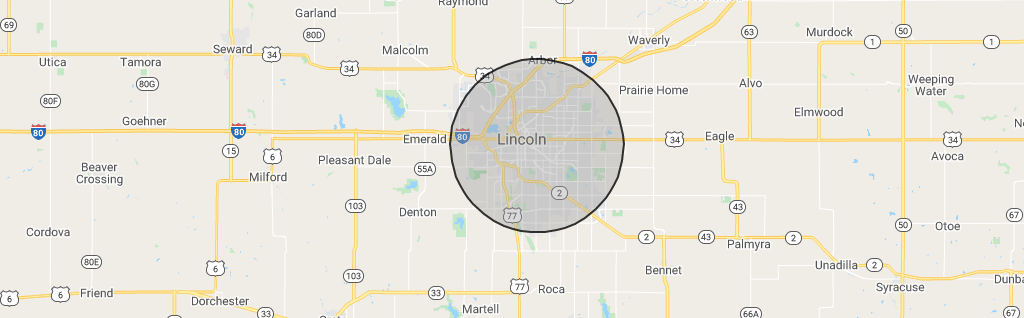

####**Collecting only COVID related tweets**
**Note:** There are 36 terms related to covid. We run query for each term<br>
**Theoretically** should fetch a total of **36** * **200** = **7200** tweets but due to **limitations** imposed by **Twitter Api** it only gets a total of 1628 tweets. 

In [ ]:
covid_related_words = ["corona", "coronavirus", "covid",
               "covid19", "covid-19", "sarscov2",
               "sars cov2", "sars cov 2", "covid_19", "ncov", 
               "ncov2019", "2019-ncov",  "pandemic",  "2019ncov",
               "quarantine", "flatten the curve", "flattening the curve",
               "hand sanitizer", "lockdown", "social distancing",
               "work from home", "working from home", "ppe",
               "n95",  "covidiots", "herd immunity", "pneumonia", 
               "chinese virus", "wuhan virus", "kung flu", "wearamask",
               "wear a mask", "vaccine", "vaccines","corona vaccine",
               "corona vaccines"]

result = []
for crw in covid_related_words:
  search_words = crw + '-filter:retweets'
  result.append(tw.Cursor(api.search,
                          q=search_words,
                          geocode='40.806862,-96.681679,10km',      
                          lang='en').items(200))

####**Writing the result to a CSV file.**

In [ ]:
tweets = []
for tweets_per_crw in result:
  for tweet in tweets_per_crw:
    location = tweet.user.location
    tweet_txt = tweet.text
    # Double check location is indeed 'Lincoln'
    if 'lincoln' in location.lower():
      print([location, tweet_txt])
      tweets.append([location, tweet_txt])

# Start writing to csv file
fields = ['location','tweet']
write_to_csv(tweets, 'covid-tweets', fields)

####**Collect all general tweets.**
**Note:** We run a query to collect a total of **5000** tweets so that we would still have enough tweets left after the preprocessing phase is completed.<br>
We only get **4807** tweets due the **limitations** imposed by **Twitter api**.

In [ ]:
search_words = '-filter:retweets'
result = tw.Cursor(api.search,
              q=search_words,
              geocode='40.806862,-96.681679,10km',      
              lang='en').items(5000)

####**Writing the result to a CSV file.**

In [ ]:
tweets = []
for tweet in result:
  location = tweet.user.location
  tweet_txt = tweet.text
  # Double check location is indeed 'Lincoln'
  if 'lincoln' in location.lower():
    tweets.append([location, tweet_txt])

# Start writing to csv file
fields = ['location','tweet']
write_to_csv(tweets, 'general-tweets', fields)

#**Pre-processing the tweets in the csv file.**<hr>

####**Pre-processing in covid-tweets.csv file.**

In [ ]:
df = pd.read_csv('/content/google_drive/My Drive/Fall 2020/Machine-learning/project/covid-tweets.csv')
tweets = df['tweet']
processed_tweets = [p.clean(tweet) for tweet in tweets]
locations = df['location']
cleaned_data = np.column_stack((locations, processed_tweets))

# Start writing to csv file
write_to_csv(cleaned_data, 'clean-covid-tweets')

for i in range(5):
  print('***    Before pre-processing:    ***')
  print(tweets[i])
  print('***    After pre-processing:    ***')
  print(processed_tweets[i])
  print()

NameError: ignored

####**Pre-processing in general-tweets.csv file.**
Note: Before we start cleaning the general tweets, we need to Filter out all the covid related tweets from the dataset.

In [ ]:
covid_related_words = ["corona", "coronavirus", "covid",
               "covid19", "covid-19", "sarscov2",
               "sars cov2", "sars cov 2", "covid_19", "ncov", 
               "ncov2019", "2019-ncov",  "pandemic",  "2019ncov",
               "quarantine", "flatten the curve", "flattening the curve",
               "hand sanitizer", "lockdown", "social distancing",
               "work from home", "working from home", "ppe",
               "n95",  "covidiots", "herd immunity", "pneumonia", 
               "chinese virus", "wuhan virus", "kung flu", "wearamask",
               "wear a mask", "vaccine", "vaccines","corona vaccine",
               "corona vaccines"]

crw_str = ''
for crw in covid_related_words:
  crw_str = crw_str + crw + '|'
print('crw_str:')
print(crw_str[:-1])

df = pd.read_csv('/content/google_drive/My Drive/Fall 2020/Machine-learning/project/general-tweets.csv')
tweets = df['tweet']

# Filter out all the covid related tweets from the general tweets dataset
non_covid_df = df[~df['tweet'].str.contains(crw_str[:-1], na=False, case=False)]
non_covid_tweets = non_covid_df['tweet']

# Finally Cleaning|Preprocessing the non covid tweets
processed_tweets = [p.clean(tweet) for tweet in non_covid_tweets]
locations = non_covid_df['location']
cleaned_data = np.column_stack((locations, processed_tweets))

# Start writing to csv file
write_to_csv(cleaned_data, 'clean-non-covid-tweets')

for i in range(5):
  print('***    Before pre-processing:    ***')
  print(tweets[i])
  print('***    After pre-processing:    ***')
  print(processed_tweets[i])
  print()

crw_str:
corona|coronavirus|covid|covid19|covid-19|sarscov2|sars cov2|sars cov 2|covid_19|ncov|ncov2019|2019-ncov|pandemic|2019ncov|quarantine|flatten the curve|flattening the curve|hand sanitizer|lockdown|social distancing|work from home|working from home|ppe|n95|covidiots|herd immunity|pneumonia|chinese virus|wuhan virus|kung flu|wearamask|wear a mask|vaccine|vaccines|corona vaccine|corona vaccines
***    Before pre-processing:    ***
#Imps player ratings from the defeat to Doncaster 

https://t.co/e4xT83JlvY
***    After pre-processing:    ***
player ratings from the defeat to Doncaster

***    Before pre-processing:    ***
@EricTrump If America elects these creepy people then we are officially the DUMBEST PEOPLE TO EVER WALK THE PLANET.  TRUMP 2020
***    After pre-processing:    ***
If America elects these creepy people then we are officially the DUMBEST PEOPLE TO EVER WALK THE PLANET. TRUMP

***    Before pre-processing:    ***
The amount of #antimaskers at @ValasPumkinPtch is as

####**Note: We have Successfully *cleaned and separated* COVID related dataset from non-COVID related dataset.**

####**Adding labels to the datasets and combining them.<br>**
**covid-tweets: 1** <br>
**non-covid-tweets: 0**

In [ ]:
# Cleaned Covid tweets dataset
covid_df = pd.read_csv('/content/google_drive/My Drive/Fall 2020/Machine-learning/project/clean-covid-tweets.csv')
covid_df['covid'] = pd.Series(1, index=covid_df.index)

# Cleaned Non covid tweets dataset
non_covid_df = pd.read_csv('/content/google_drive/My Drive/Fall 2020/Machine-learning/project/clean-non-covid-tweets.csv')
non_covid_df['covid'] = pd.Series(0, index=non_covid_df.index)

####**Combining the two dataframes and Saving them for future.**

In [ ]:
dfs = [covid_df, non_covid_df]
combined_df = pd.concat(dfs)
combined_df.reset_index(drop=True, inplace=True)

combined_df.to_csv('cleaned-covid-non-covid-tweets.csv')

#**Beginning of Exploratory Data Analysis.**<hr>

####**Accessing the Preprocessed Dataset with covid and non covid tweets distinctly labeled.**

In [ ]:
main_df = pd.read_csv('/content/google_drive/My Drive/Fall 2020/Machine-learning/project/cleaned-covid-non-covid-tweets.csv')

main_df.drop('Unnamed: 0', axis=1, inplace=True)  # Drop garbage column in place

print('**** Before Dropping null rows will null values ****')
print('     Number of rows', main_df.shape[0])
print('     Number of columns', main_df.shape[1])

if main_df.isna().values.any():
  main_df.dropna(inplace=True)
  main_df.reset_index(inplace=True, drop=True)
  print('**** After Dropping null rows will null values ****')
  print('     Number of rows', main_df.shape[0])
  print('     Number of columns', main_df.shape[1])

main_df.head(5)

**** Before Dropping null rows will null values ****
     Number of rows 6211
     Number of columns 3
**** After Dropping null rows will null values ****
     Number of rows 6201
     Number of columns 3


location                                              tweet  covid
0  Lincoln, Nebraska  The corona is separated from the photosphere b...      1
1  Lincoln, Nebraska  The corona is ^-12 times as dense as the photo...      1
2  Lincoln, Nebraska  The photosphere's average temperature is kelvi...      1
3        Lincoln, NE  In related news CP cancels quarterfinal game d...      1
4  Lincoln, Nebraska  The sun's corona is much hotter (by a factor o...      1

####**Shuffling the rows of the given dataset**
**Note:** We shuffle the rows in the dataset in order to introduce randomness in the dataset. 

In [ ]:
main_df = main_df.sample(frac=1)

####**Class Distribution**<br>
covid-tweets: 1<br>
non-covid-tweets: 0

In [ ]:
main_df.groupby('covid').count()

location  tweet
covid                 
0          4575   4575
1          1626   1626

####**Generating bar plots for class distribution**

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


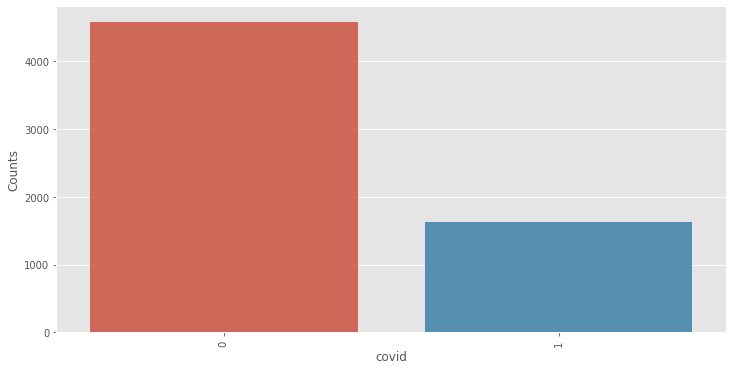

CPU times: user 152 ms, sys: 13.7 ms, total: 166 ms
Wall time: 197 ms


In [ ]:
%%time

label_counts = main_df.covid.value_counts()
plt.figure(figsize = (12,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)

plt.xticks(rotation = 'vertical')
plt.xlabel('covid', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

####**Correlation between the tweets length & the class(covid / non-covid)**<br>
covid-tweets: 1<br>
non-covid-tweets: 0<br><br>
Clearly, tweets that are covid related have smaller length.

In [ ]:
main_df['length'] = main_df['tweet'].map(lambda text: len(text))
main_df.groupby('covid').length.describe()

count       mean        std  min   25%    50%    75%    max
covid                                                              
0      4575.0  58.834754  34.900186  4.0  27.0   55.0   91.0  140.0
1      1626.0  92.206642  24.608048  5.0  79.0  100.0  113.0  137.0

####**Visualize length distribution by class**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fed7ebcb630>,
      dtype=object)

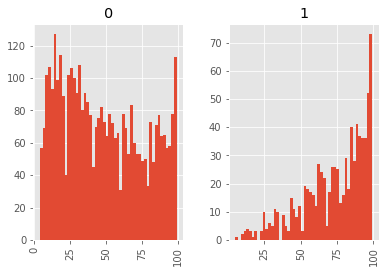

In [ ]:
tweets_ = main_df[main_df.length < 100]
tweets_.hist(column='length', by='covid', bins=50)

###**Observation from the EDA**<br>
We observer that tweets related to covid are generally smaller with occasional outliers (long tweets).

#**Feature Extraction for Text Analytics**
Feature extraction is a process of extracting important features from the given dataset.<br>
**What is a feature?**<br>
A feature is anything that can correctly represent the given data. For example: a word is feature, its occurrence frequency in the given dataset is another feature, and they together they can represent the given data.<br><br>
###**Steps in Feature Extraction**
Generally there are three steps in feature extraction.

1.  **Text Normalization (Stemming & Lemmatization)**
2.   **Text Preprocessing (Tokenization, removing stop words, etc.)**
3.   **Vectorization of the features**

<hr>

##**Text Normalization**
**Why Text Normalization?**<br>
Languages we speak and write contains several words that are often derived from one another, and Text Normalization reduces those words to their root form to speed up the learning process.<br><br>
**Stemming** and **Lemmatization** are Text Normalization (or sometimes called Word Normalization) techniques in the field of Natural Language Processing that are used to prepare text, words, and documents for further processing.

**Lemmatization** is more suitable for text classification. It's the process of grouping together the inflected forms of a word so they can be analyzed as a single item, identified by the word's lemma, or dictionary form. So words like 'moved' & 'moving' will be reduced to 'move'.

In this research, we will **explore 3 text Normalization** technique.


1.   **Lemmatization**
2.   **Stemming**
3.   **Lemmatization & Stemming**



####**1. Lemmatization**

In [ ]:
%%time
lemmatizer = WordNetLemmatizer()

main_df['tweet_lemma'] = main_df['tweet'].map(lambda text: ' '.join(lemmatizer.lemmatize(w)
for w in nltk.word_tokenize(text.lower())))

CPU times: user 3.38 s, sys: 191 ms, total: 3.58 s
Wall time: 3.61 s


####**2. Stemming**

In [ ]:
%%time
stemmer = PorterStemmer()

main_df['tweet_stemm'] = main_df['tweet'].map(lambda text: ' '.join(stemmer.stem(w)
for w in nltk.word_tokenize(text.lower())))

CPU times: user 2.62 s, sys: 8.04 ms, total: 2.63 s
Wall time: 2.63 s


####**3. Lemmatization & Stemming**

In [ ]:
%%time
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

main_df['tweet_lemma&stemm'] = main_df['tweet'].map(lambda text: ' '.join(stemmer.stem(lemmatizer.lemmatize(w))
for w in nltk.word_tokenize(text.lower())))

CPU times: user 3.18 s, sys: 3.58 ms, total: 3.18 s
Wall time: 3.19 s


####**New Dataframe.**

In [ ]:
main_df.head()

location  ...                                  tweet_lemma&stemm
4792     Lincoln, NE  ...                after today it offici christma time
3047  Lincoln NE USA  ...                          elizabeth katt - live via
1020     Lincoln, NE  ...  one reason that i hate the pandem is becaus we...
1972     Lincoln, NE  ...                   ha . never mind ! ! nice catch .
3117     Lincoln, NE  ...  space cadet . i believ you meant he is corrupt...

[5 rows x 7 columns]

##**Text Preprocessing**
**Why Text Preprocessing?**<br>
Using Text features in machine learning can be very expensive. And, Text preprocessing **tokenizes the texts, removes the stop words and converts textual features to a matrix of token count** form that is easily computed by a machine learning model.<br><br>

**What are Stop Words?**<br>
Stop words are words like "and", "the", "him", which are presumed to be uninformative in representing the content of a text.<br>

<br>At the end of Text Preprocessing we are left with a **sparse representation** of the counts using scipy.sparse.csr_matrix.<br>

In order to convert the features to a matrix of tokens we use two types of **feature(word) embeddings.**

**What is word embedding?**<br>
Word embedding is a numerical representations of texts using in a sparse matrix format.

1.   **Frequency based word embedding**
2.   **Prediction based word embedding**


###**Frequency based embedding**
The frequency based methods use deterministic methods to compute word vectors. They don't consider the contextual nature of the words in the text while creating numerical representation<br>

**There are mainly two types of vectors under this category**

1.   **Count Vectors** obtained Bag of Words using CountVectorizer()
2.   **TF-IDF vectors** obtained using TFidfTransformer()


####**Bag of Words**
**What is Bag of Words?**<br>
Bag of Words is simply a collection of words to represent a sentence or text with word count and mostly disregarding the order in which they appear.<br>
####**Limitations of the Bag of Words representation**
The bag of words model is a collection of unigrams. There are some limitations of this model:

1.   It cannot capture phrases and multi-word expressions.
2.   It effectively disregards any word order dependence.
3.   It doesn’t account for potential misspellings or word derivations.

A **better** and sophisticated model for feature representation is the **n-grams model**. Instead of building a simple collection of unigrams (n=1), one might prefer a collection of bigrams (n=2), where occurrences of pairs of consecutive words are counted.<br>
We will be experimenting with different n-grams for correct representation of give data.




####**Unigram or n-grams=1 Bag of words model**
For Lemmatized, Stemmed, and Lemmatized & Stemmed tweets

In [ ]:
count_vect = CountVectorizer(lowercase=True, stop_words='english')

# For Lemmatized tweets
uni_X_counts_lemma = count_vect.fit_transform(main_df['tweet_lemma'])
uni_X_features_lemma = count_vect.get_feature_names()
print('Lemmatized tweets')
print('Features:', uni_X_features_lemma)
print('Vocabulary: ', count_vect.vocabulary_)

# For Stemmed tweets
uni_X_counts_stemm = count_vect.fit_transform(main_df['tweet_stemm'])
uni_X_features_stemm = count_vect.get_feature_names()
print('\nStemmed tweets')
print('Features:', uni_X_features_stemm)
print('Vocabulary: ', count_vect.vocabulary_)

# For Lemmatized & Stemmed tweets
uni_X_counts_lemma_stemm = count_vect.fit_transform(main_df['tweet_lemma&stemm'])
uni_X_features_lemma_stemm = count_vect.get_feature_names()
print('\nLemmatized and Stemmed tweets')
print('Features:', uni_X_features_lemma_stemm)
print('Vocabulary: ', count_vect.vocabulary_)


Lemmatized tweets
Features: ['00', '000', '00am', '01', '01am', '02b1ab', '05b1ab', '05b72', '06b1ab', '07', '0713', '07b1ab', '08', '08b1ab', '09', '10', '100k', '105mm', '10a', '11', '12', '13', '13b1ab', '14', '14b1ab', '15b1ab', '169', '16b72', '17', '171a', '17b1ab', '18', '19', '19b1ab', '19b72', '1b', '1million', '20', '200', '200k', '2010', '2018', '2020', '208', '20b1ab', '20pm', '21', '22', '24', '25', '250', '25am', '26', '28', '28b1ab', '299', '29b72', '2nd', '2pm', '30', '30am', '30b1ab', '30b4a', '30pm', '31', '33', '34k', '35', '36am', '37', '3b', '3bath', '400k', '402', '44m', '45pm', '475', '49', '490ishwo', '50', '500', '500altria', '500brooks', '500business', '500carpenters', '500centene', '500centurylink', '500eggers', '500fairchild', '500friesen', '500hawkins', '500johnson', '500lincoln', '500magnuson', '500merck', '500mutual', '500naifadirect', '500ne', '500steamfitters', '500tenaska', '500thayer', '54', '56am', '5illinois', '5oklahoma', '605', '65m', '6pm', '70',

####**Bigram or n-grams=2 Bag of words model**
For Lemmatized, Stemmed, and Lemmatized & Stemmed tweets

In [ ]:
count_vect = CountVectorizer(lowercase=True, stop_words='english', analyzer='word', ngram_range=(1,2))

# For Lemmatized tweets
bi_X_counts_lemma = count_vect.fit_transform(main_df['tweet_lemma'])
bi_X_features_lemma = count_vect.get_feature_names()
print('Lemmatized tweets')
print('Features:', bi_X_features_lemma)
print('Vocabulary: ', count_vect.vocabulary_)

# For Stemmed tweets
bi_X_counts_stemm = count_vect.fit_transform(main_df['tweet_stemm'])
bi_X_features_stemm = count_vect.get_feature_names()
print('\nStemmed tweets')
print('Features:', bi_X_features_stemm)
print('Vocabulary: ', count_vect.vocabulary_)

# For Lemmatized & Stemmed tweets
bi_X_counts_lemma_stemm = count_vect.fit_transform(main_df['tweet_lemma&stemm'])
bi_X_features_lemma_stemm = count_vect.get_feature_names()
print('\nLemmatized and Stemmed tweets')
print('Features:', bi_X_features_lemma_stemm)
print('Vocabulary: ', count_vect.vocabulary_)


Output hidden; open in https://colab.research.google.com to view.

####**Trigram or n-grams=3 Bag of words model.  !!! NO NEED TO RUN. !!!**
For Lemmatized, Stemmed, and Lemmatized & Stemmed tweets

In [ ]:
count_vect = CountVectorizer(lowercase=True, stop_words='english', analyzer='word', ngram_range=(1,3))

# For Lemmatized tweets
tri_X_counts_lemma = count_vect.fit_transform(main_df['tweet_lemma'])
tri_X_features_lemma = count_vect.get_feature_names()
print('Lemmatized tweets')
print('Features:', tri_X_features_lemma)
print('Vocabulary: ', count_vect.vocabulary_)

# For Stemmed tweets
tri_X_counts_stemm = count_vect.fit_transform(main_df['tweet_stemm'])
tri_X_features_stemm = count_vect.get_feature_names()
print('\nStemmed tweets')
print('Features:', tri_X_features_stemm)
print('Vocabulary: ', count_vect.vocabulary_)

# For Lemmatized & Stemmed tweets
tri_X_counts_lemma_stemm = count_vect.fit_transform(main_df['tweet_lemma&stemm'])
tri_X_features_lemma_stemm = count_vect.get_feature_names()
print('\nLemmatized and Stemmed tweets')
print('Features:', tri_X_features_lemma_stemm)
print('Vocabulary: ', count_vect.vocabulary_)

####**TF-IDF**
**What is Term Frequency-Inverse Document Frequency (TF-IDF)?**<br>
**TF-IDF** is a technique to quantify a word in documents and find out how relevant they are in the given context.<br>
For example:&emsp;In a large text corpus, some words might show up very frequently, but only carry less meaningful information. And these words because of the frequency might overshadow the contribution of less frequent words that may carry higly meaningful information.<br><br>

**TF-IDF is widely used in Information Retrieval and Text Mining.**

In [ ]:
tfidf_vect = TfidfVectorizer()

# Lemmatized
tfidf_X_counts_lemma = tfidf_vect.fit_transform(main_df['tweet_lemma'])
tfidf_X_features_lemma = tfidf_vect.get_feature_names()
print('Lemmatized tweets')
print('Features:', tfidf_X_features_lemma)
print('Vocabulary: ', tfidf_vect.vocabulary_)

# Stemmed
tfidf_X_counts_stemm = tfidf_vect.fit_transform(main_df['tweet_stemm'])
tfidf_X_features_stemm = tfidf_vect.get_feature_names()
print('\nStemmed tweets')
print('Features:', tfidf_X_features_stemm)
print('Vocabulary: ', tfidf_vect.vocabulary_)

# Lemmatized & Stemmed
tfidf_X_counts_lemma_stemm = tfidf_vect.fit_transform(main_df['tweet_lemma&stemm'])
tfidf_X_features_lemma_stemm = tfidf_vect.get_feature_names()
print('\nLemmatized & Stemmed tweets')
print('Features:', tfidf_X_features_lemma_stemm)
print('Vocabulary: ', tfidf_vect.vocabulary_)

Lemmatized tweets
Features: ['00', '000', '00am', '01', '01am', '02b1ab', '05b1ab', '05b72', '06b1ab', '07', '0713', '07b1ab', '08', '08b1ab', '09', '10', '100k', '105mm', '10a', '11', '12', '13', '13b1ab', '14', '14b1ab', '15b1ab', '169', '16b72', '17', '171a', '17b1ab', '18', '19', '19b1ab', '19b72', '1b', '1million', '20', '200', '200k', '2010', '2018', '2020', '208', '20b1ab', '20pm', '21', '22', '24', '25', '250', '25am', '26', '28', '28b1ab', '299', '29b72', '2nd', '2pm', '30', '30am', '30b1ab', '30b4a', '30pm', '31', '33', '34k', '35', '36am', '37', '3b', '3bath', '400k', '402', '44m', '45pm', '475', '49', '490ishwo', '50', '500', '500altria', '500brooks', '500business', '500carpenters', '500centene', '500centurylink', '500eggers', '500fairchild', '500friesen', '500hawkins', '500johnson', '500lincoln', '500magnuson', '500merck', '500mutual', '500naifadirect', '500ne', '500steamfitters', '500tenaska', '500thayer', '54', '56am', '5illinois', '5oklahoma', '605', '65m', '6pm', '70',

###**Prediction based embedding**
Prediction based embedding is a powerful way to compute the word vectors that actually considers the contextual nature of the words in the text while creating numerical representation.<br>

There are mainly two methods of creating word vectors in this category.

1.   Word2vec
2.   Doc2vec



####**1. Word2Vec**

A Word2Vec model is a simple ANN with a singel hidden layer. It is helpful to use Word2Vec model if our objective is to have words with similar context occupy close spatial position or similar vector representation.<br>
It converts words into vectors by encoding their contextual information (relation of a word with other words in the Text corpus). So, it is very useful for sematic understanding of the words.<br>
<br>
A Word2Vec model implementation involves 2 tasks:

1.   Pre-process Data
2.   Create word embeddings and training the Word2vec model

####**Note**:
We have already completed Pre-processing data. Now we create the word embeddings.<br>


#####**Function for creating the Word2vec features from the tokenized words.**

In [ ]:
def get_w2v_features(w2v_model, words):
    """ Transform a sentence_group (containing multiple lists
    of words) into a feature vector. It averages out all the
    word vectors of the sentence_group.
    """
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # Initialize a counter for number of words in a review
    nwords = 0
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.

    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    
    return featureVec

#####**Function for computing the bigrams and trigrams**
We compute the bigrams and trigrams in order to find words that might create meaningful information when appeared together.

In [ ]:
def compute_bi_tri_grams(docs):
  bigram = Phrases(docs, min_count=10)
  trigram = Phrases(bigram[docs])

  for idx in range(len(docs)):
      for token in bigram[docs[idx]]:
          if '_' in token:
              # Token is a bigram, add to document.
              docs[idx].append(token)
      for token in trigram[docs[idx]]:
          if '_' in token:
              # Token is a bigram, add to document.
              docs[idx].append(token)

#####**Training the Word2vec Model**

######**Setting up the training parameters for the model. Obtained from DR. Hasan's Notebook**

In [ ]:
# Set training parameters
size = 300       # Dimension of the word vector
window_size = 2  # We set it 2 as the sentences weren't too long
epochs = 100     # Number of iterations (epochs) over the corpus.
min_count = 2    # Ignores all words with total frequency lower than this.
workers = 4

######**Lemmatized**

In [ ]:
%%time

docs = main_df['tweet_lemma'].map(lambda text: nltk.word_tokenize(text))

# Computing bi-grams and tri-grams and adding them to the docs
compute_bi_tri_grams(docs)

# Train Word2vec model using gensim (use the skip-gram model: sg = 1)
model = Word2Vec(docs, sg=1,window=window_size,size=size, min_count=min_count,workers=workers,iter=epochs,sample=0.01)

X = []

for text in docs:
  X.append(get_w2v_features(model, text))
w2v_X_counts_lemma = np.asarray(X)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


CPU times: user 1min 8s, sys: 438 ms, total: 1min 8s
Wall time: 39.3 s


######**Stemmed**

In [ ]:
%%time

docs = main_df['tweet_stemm'].map(lambda text: nltk.word_tokenize(text))

# Computing bi-grams and tri-grams and adding them to the docs
compute_bi_tri_grams(docs)

# Train Word2vec model using gensim (use the skip-gram model: sg = 1)
model = Word2Vec(docs, sg=1,window=window_size,size=size, min_count=min_count,workers=workers,iter=epochs,sample=0.01)

X = []
for text in docs:
  X.append(get_w2v_features(model, text))
w2v_X_counts_stemm = np.asarray(X)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


CPU times: user 1min 7s, sys: 797 ms, total: 1min 7s
Wall time: 38.8 s


######**Lemmatized & Stemmed**

In [ ]:
%%time

docs = main_df['tweet_lemma&stemm'].map(lambda text: nltk.word_tokenize(text))

# Computing bi-grams and tri-grams and adding them to the docs
compute_bi_tri_grams(docs)

# Train Word2vec model using gensim (use the skip-gram model: sg = 1)
model = Word2Vec(docs, sg=1,window=window_size,size=size, min_count=min_count,workers=workers,iter=epochs,sample=0.01)

X = []
for text in docs:
  X.append(get_w2v_features(model, text))
w2v_X_counts_lemma_stemm = np.asarray(X)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


CPU times: user 1min 7s, sys: 402 ms, total: 1min 7s
Wall time: 38.6 s


######**Model Evaluation**
Printing list of similar words to 'covid' with their similarity values.<br>
Based on the similarity values, 'treatment' seems to be the most similar to 'covid'.

In [ ]:
model.wv.similar_by_word('covid', topn=5)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('treatment', 0.421367347240448),
 ('covid-19', 0.4159590005874634),
 ('vener', 0.4119521379470825),
 ('pneumonia', 0.4028362035751343),
 ('czar', 0.38853245973587036)]

####**2. Doc2vec**
The Doc2vec model is created by slightly augmenting the Word2vec model.<br>
More formally it's a small extension to the Continuous Bag-of-Words (CBOW) Word2vec model. Instead of using just words to predict the next word, it also adds another feature vector, which is document-unique.

#####**Training the Doc2vec Model**

######**Setting up the training parameters for the model.**

In [ ]:
%%time
# Set training parameters
doc_vector_length = 300       # Dimension of the document vector
window_size = 2               # We set it 2 as the sentences weren't too long
epochs = 600                  # Number of iterations (epochs) over the corpus
min_count = 1                 # Ignores all words with total frequency lower than min_count
workers = 4                   # Number of worker threads to train the model

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


######**Lemmatized**

In [ ]:
%%time
docs = main_df['tweet_lemma'].map(lambda text: nltk.word_tokenize(text))

# We need to create Tagged documents for training the Doc2vec model
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(docs)]

# Create the Doc2vec model using gensim (If dm=1, ‘distributed memory’ (DM) algorithm is used)
model = Doc2Vec(vector_size=doc_vector_length, dm=1, window=window_size, min_count=min_count, 
                workers=workers, sample=0.01, epochs=epochs)
# Create vocabulary
model.build_vocab(documents)

# Train the model
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)
noOfDocuments = len(documents)

X = np.empty([noOfDocuments, doc_vector_length])

for i in range(noOfDocuments):
    X[i] = model.docvecs[i].reshape(1, -1)
    
d2v_X_counts_lemma = np.asarray(X)

CPU times: user 12min 56s, sys: 3min 16s, total: 16min 12s
Wall time: 11min 11s


######**Stemmed**

In [ ]:
%%time
docs = main_df['tweet_stemm'].map(lambda text: nltk.word_tokenize(text))

# We need to create Tagged documents for training the Doc2vec model
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(docs)]

# Create the Doc2vec model using gensim (If dm=1, ‘distributed memory’ (DM) algorithm is used)
model = Doc2Vec(vector_size=doc_vector_length, dm=1, window=window_size, min_count=min_count, 
                workers=workers, sample=0.01, epochs=epochs)
# Create vocabulary
model.build_vocab(documents)

# Train the model
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)
noOfDocuments = len(documents)

X = np.empty([noOfDocuments, doc_vector_length])

for i in range(noOfDocuments):
    X[i] = model.docvecs[i].reshape(1, -1)
    
d2v_X_counts_stemm = np.asarray(X)

CPU times: user 12min 42s, sys: 3min 28s, total: 16min 10s
Wall time: 11min 10s


######**Lemmatized & Stemmed**

In [ ]:
%%time
docs = main_df['tweet_lemma&stemm'].map(lambda text: nltk.word_tokenize(text))

# We need to create Tagged documents for training the Doc2vec model
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(docs)]

# Create the Doc2vec model using gensim (If dm=1, ‘distributed memory’ (DM) algorithm is used)
model = Doc2Vec(vector_size=doc_vector_length, dm=1, window=window_size, min_count=min_count, 
                workers=workers, sample=0.01, epochs=epochs)
# Create vocabulary
model.build_vocab(documents)

# Train the model
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)
noOfDocuments = len(documents)

X = np.empty([noOfDocuments, doc_vector_length])

for i in range(noOfDocuments):
    X[i] = model.docvecs[i].reshape(1, -1)
    
d2v_X_counts_lemma_stemm = np.asarray(X)

CPU times: user 12min 47s, sys: 3min 32s, total: 16min 19s
Wall time: 11min 18s


##**Visualization of Text data**
There are many techniques to visualize words.

1.   **Word Cloud**
2.   **Dimensionality Reduction (2D)**

**Word Cloud** is a technique to visualize words in **Text Normalization Section**. Word Cloud displays words in varying size based on their frequency in the Text Corpus. But, it doesn't show any contextual information.<br>

Two common techniques to reduce the dimensionality of the data are:

1.   **PCA**
2.   **t-SNE**


###**Word Cloud Visualization of non-covid tweets vs covid tweet.**

####**1. Lemmatized**

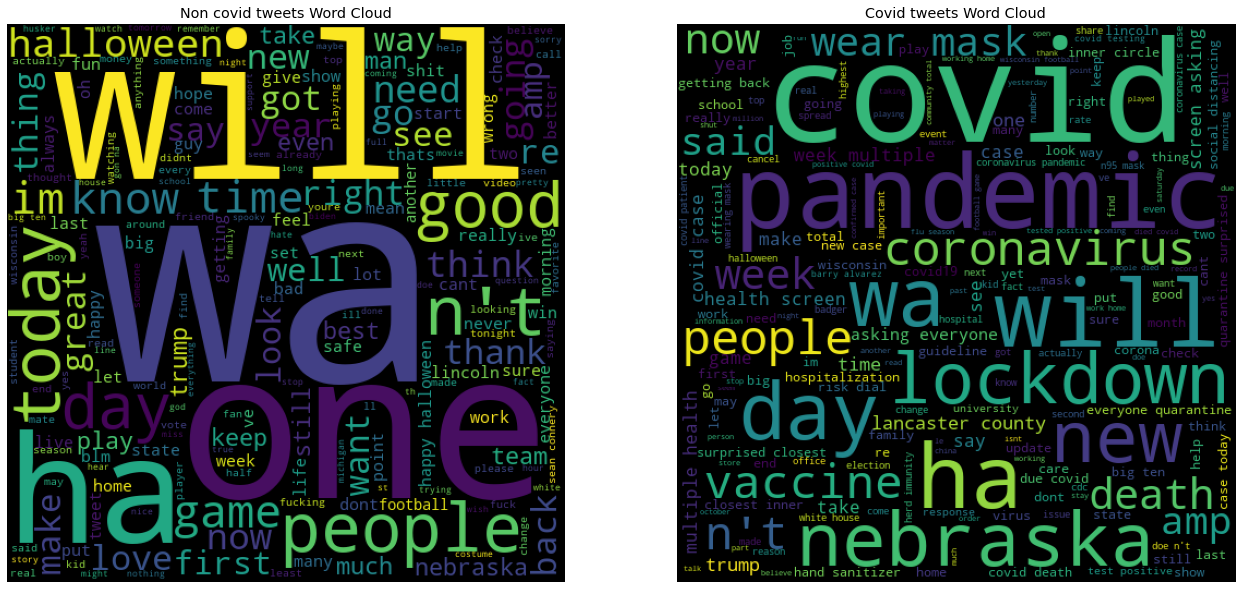

In [ ]:
non_covid_tweet_words = ''.join(list(main_df[main_df['covid'] == 0]['tweet_lemma']))
non_covid_tweet_wordcloud = WordCloud(width = 512,height = 512).generate(non_covid_tweet_words)

covid_tweet_words = ''.join(list(main_df[main_df['covid'] == 1]['tweet_lemma']))
covid_tweet_wordcloud = WordCloud(width = 512,height = 512).generate(covid_tweet_words)

fig, ax = plt.subplots(1, 2, figsize = (22, 13))

ax[0].imshow(non_covid_tweet_wordcloud)
ax[0].set_title('Non covid tweets Word Cloud')
ax[0].set_axis_off()

ax[1].imshow(covid_tweet_wordcloud)
ax[1].set_title('Covid tweets Word Cloud')
ax[1].set_axis_off()

fig.subplots_adjust(wspace=0.2)
plt.show()

####**2. Stemmed**

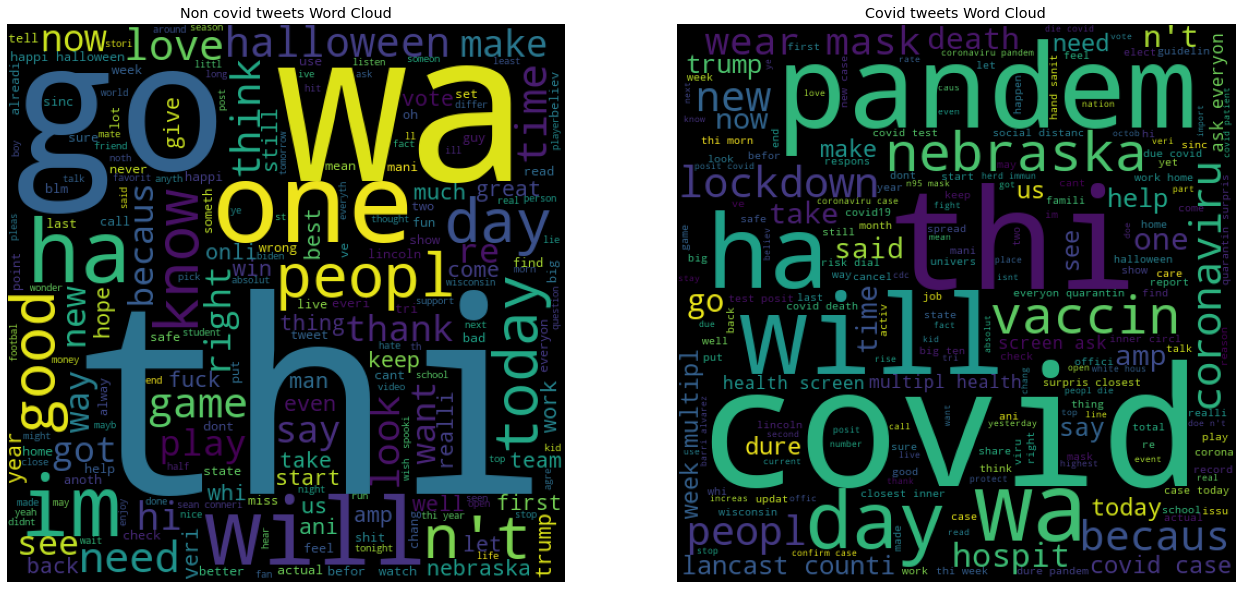

In [ ]:
non_covid_tweet_words = ''.join(list(main_df[main_df['covid'] == 0]['tweet_stemm']))
non_covid_tweet_wordcloud = WordCloud(width = 512,height = 512).generate(non_covid_tweet_words)

covid_tweet_words = ''.join(list(main_df[main_df['covid'] == 1]['tweet_stemm']))
covid_tweet_wordcloud = WordCloud(width = 512,height = 512).generate(covid_tweet_words)

fig, ax = plt.subplots(1, 2, figsize = (22, 13))

ax[0].imshow(non_covid_tweet_wordcloud)
ax[0].set_title('Non covid tweets Word Cloud')
ax[0].set_axis_off()

ax[1].imshow(covid_tweet_wordcloud)
ax[1].set_title('Covid tweets Word Cloud')
ax[1].set_axis_off()

fig.subplots_adjust(wspace=0.2)
plt.show()

####**3. Lemmatized & Stemmed**

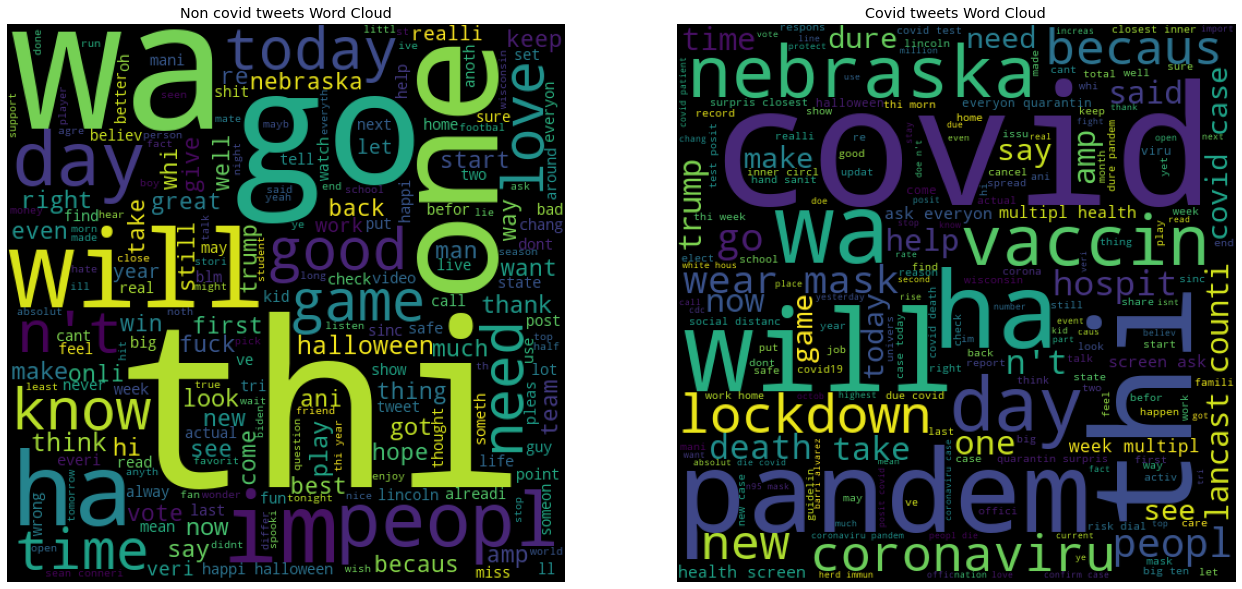

In [ ]:
non_covid_tweet_words = ''.join(list(main_df[main_df['covid'] == 0]['tweet_lemma&stemm']))
non_covid_tweet_wordcloud = WordCloud(width = 512,height = 512).generate(non_covid_tweet_words)

covid_tweet_words = ''.join(list(main_df[main_df['covid'] == 1]['tweet_lemma&stemm']))
covid_tweet_wordcloud = WordCloud(width = 512,height = 512).generate(covid_tweet_words)

fig, ax = plt.subplots(1, 2, figsize = (22, 13))

ax[0].imshow(non_covid_tweet_wordcloud)
ax[0].set_title('Non covid tweets Word Cloud')
ax[0].set_axis_off()

ax[1].imshow(covid_tweet_wordcloud)
ax[1].set_title('Covid tweets Word Cloud')
ax[1].set_axis_off()

fig.subplots_adjust(wspace=0.2)
plt.show()

###**Using PCA to visualize data**
**PCA** stands for **Principal component analysis**. This technique of dimensionality reduction is very useful incase of **linear data**.

####**Lemmatized**

In [ ]:
pca = PCA(n_components=2, random_state=42)

val_a = pca.fit_transform(uni_X_counts_lemma.todense())
val_b = pca.fit_transform(tfidf_X_counts_lemma.todense())

inputs =[{'reduced_values': val_a, 'labels':uni_X_features_lemma, 'model_name': 'PCA (Count-Vector)'},
         {'reduced_values': val_b, 'labels':tfidf_X_features_lemma, 'model_name': 'PCA (TF-IDF-Vector)'}]

plotData(inputs)

KeyboardInterrupt: ignored

####**Stemmed**

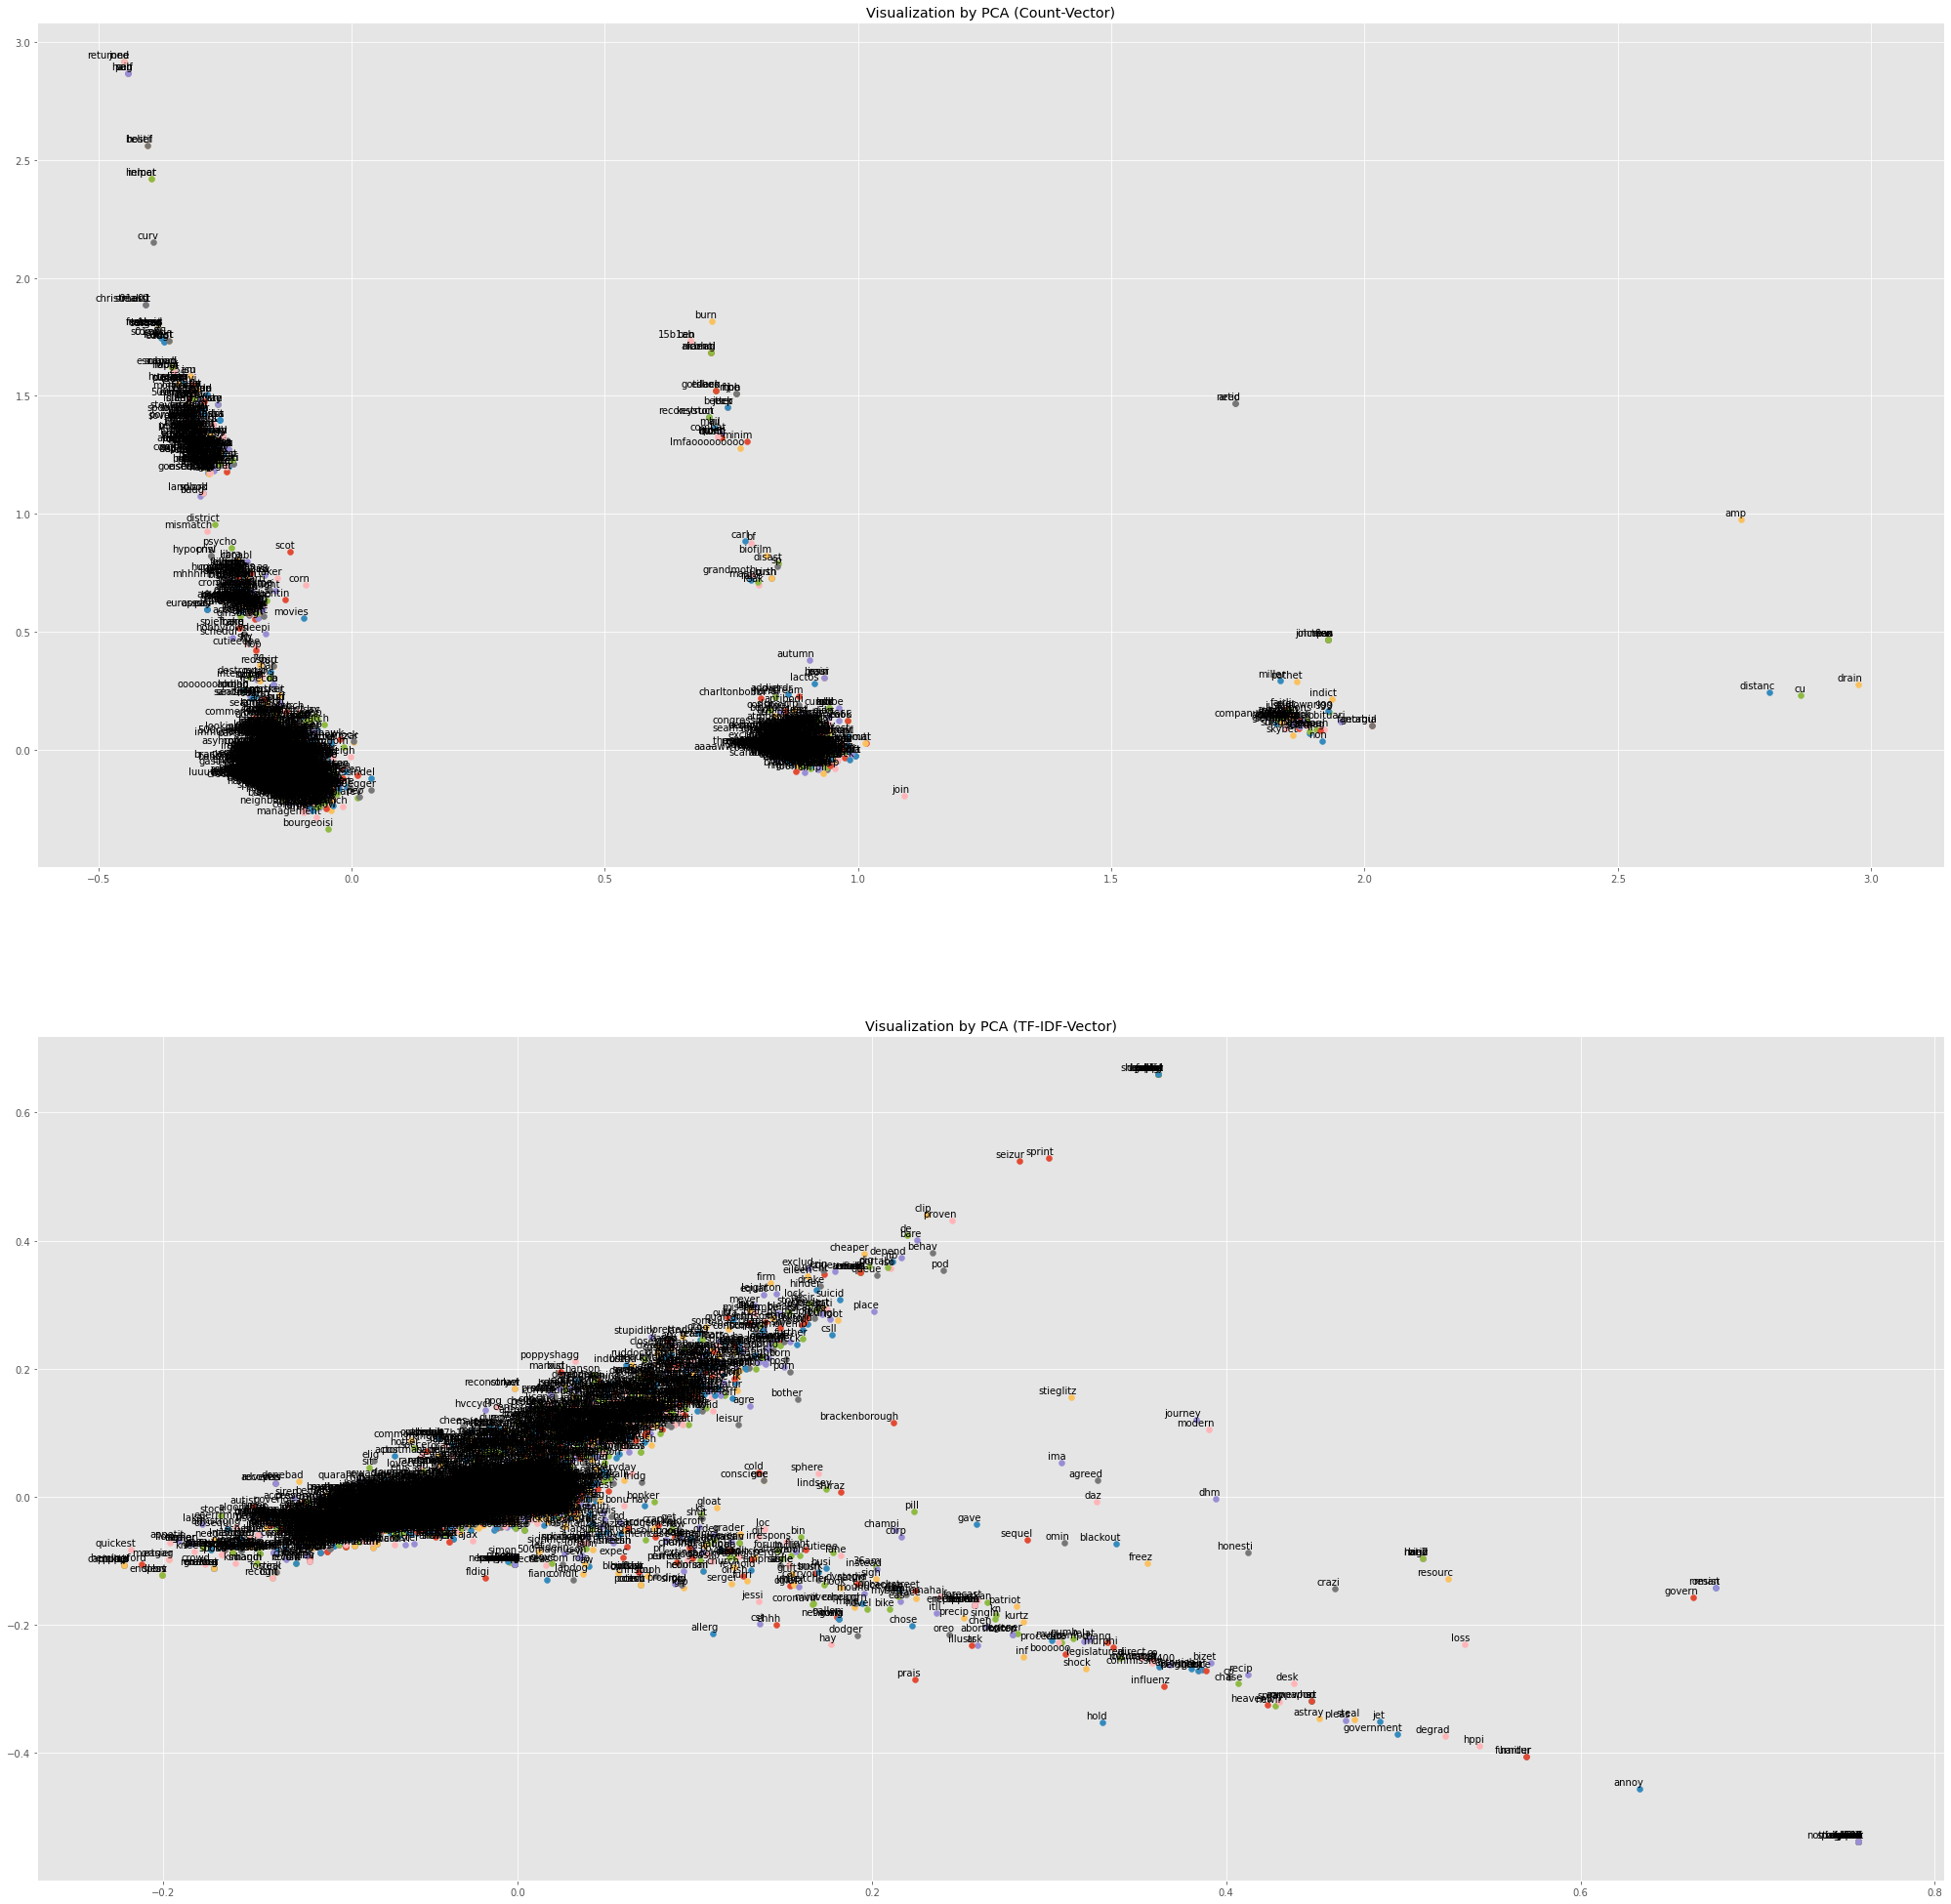

In [ ]:
pca = PCA(n_components=2, random_state=42)

val_a = pca.fit_transform(uni_X_counts_stemm.todense())
val_b = pca.fit_transform(tfidf_X_counts_stemm.todense())

inputs =[{'reduced_values': val_a, 'labels':uni_X_features_stemm, 'model_name': 'PCA (Count-Vector)'},
         {'reduced_values': val_b, 'labels':tfidf_X_features_stemm, 'model_name': 'PCA (TF-IDF-Vector)'}]

plotData(inputs)

####**Lemmatized & Stemmed**

In [ ]:
%%time
pca = PCA(n_components=2, random_state=42)

val_a = pca.fit_transform(uni_X_counts_lemma_stemm.todense())
val_b = pca.fit_transform(bi_X_counts_lemma_stemm.todense())
val_c = pca.fit_transform(tfidf_X_counts_lemma_stemm.todense())

inputs =[{'reduced_values': val_a, 'labels':uni_X_features_lemma_stemm, 'model_name': 'PCA (Count-Vector-Unigram)'},
         {'reduced_values': val_b, 'labels':bi_X_features_lemma_stemm, 'model_name': 'PCA (Count-Vector-Bigram)'},
         {'reduced_values': val_c, 'labels':tfidf_X_features_lemma_stemm, 'model_name': 'PCA (TF-IDF-Vector)'}]

plotData(inputs)

###**Using T-SNE to visualize data**
**T-SNE** stands for **T-Distributed Stochastic Neighbor Embedding**. It is a Manifold Learning technique of dimensionality reduction and is very useful incase of **non-linear data**.<br>
The **t-SNE** tries to preserve the distances in a neighborhood. It differs from PCA by preserving only small pairwise distances or local similarities whereas PCA is concerned with preserving large pairwise distances to maximize variance.

**Note:**
T-SNE would be extremely slow because of the larze size of vocabulary. That's why first we apply PCA to reduce the number of dimensions, then apply t-SNE.

####**Lemmatized**

In [ ]:
pca_tsne = Pipeline([('pca', PCA(n_components=0.95, random_state=42)),
                     ('tsne', TSNE(n_components=2, perplexity=30, random_state=42))
                     ])

val_a = pca_tsne.fit_transform(uni_X_counts_lemma.todense())
val_b = pca_tsne.fit_transform(tfidf_X_count_lemma.todense())

inputs =[{'reduced_values': val_a, 'labels':uni_X_features_lemma, 'model_name': 'T-SNE (Count-Vector)'},
         {'reduced_values': val_b, 'labels':tfidf_X_features_lemma, 'model_name': 'T-SNE (TF-IDF-Vector)'}]

plotData(inputs)

####**Stemmed**

In [ ]:
%%time

pca_tsne = Pipeline([('pca', PCA(n_components=0.95, random_state=42)),
                     ('tsne', TSNE(n_components=2, perplexity=30, random_state=42))
                     ])


val_a = pca_tsne.fit_transform(uni_X_counts_stemm.todense())
val_b = pca_tsne.fit_transform(tfidf_X_count_stemm.todense())

inputs =[{'reduced_values': val_a, 'labels':uni_X_features_stemm, 'model_name': 'T-SNE (Count-Vector)'},
         {'reduced_values': val_b, 'labels':tfidf_X_features_stemm, 'model_name': 'T-SNE (TF-IDF-Vector)'}]

plotData(inputs)

####**Lemmatized & Stemmed**

In [ ]:
%%time 

pca_tsne = Pipeline([('pca', PCA(n_components=0.95, random_state=42)),
                     ('tsne', TSNE(n_components=2, perplexity=30, random_state=42))
                     ])

val_a = pca_tsne.fit_transform(uni_X_counts_lemma_stemm.todense())
val_b = pca_tsne.fit_transform(tfidf_X_count_lemma_stemm.todense())

inputs =[{'reduced_values': val_a, 'labels':uni_X_features_stemm, 'model_name': 'T-SNE (Count-Vector)'},
         {'reduced_values': val_b, 'labels':tfidf_X_features_stemm, 'model_name': 'T-SNE (TF-IDF-Vector)'}]

plotData(inputs)

####**Helper function to visualize the word vectors**

In [ ]:
def plotData(inputs):
    fig, ax = plt.subplots(len(inputs), 1, figsize = (35, 35))
    j = 0
    
    for input in inputs:
      x = []
      y = []
      labels = input.get('labels')
      reduced_values = input.get('reduced_values')
      model_name = input.get('model_name')

      for value in input.get('reduced_values'):
          x.append(value[0])
          y.append(value[1])

      ax[j].set_title("Visualization by %s" % model_name)
      for i in range(len(x)):
          ax[j].scatter(x[i], y[i])
          ax[j].annotate(labels[i],  # text of the annotation
                      xy=(x[i], y[i]), # The point (x,y) to annotate.
                      xytext=(5, 2),   # The position (x,y) to place the text at. If None, defaults to xy.
                      textcoords='offset points', # The coordinate system that xy text is given in.
                      ha='right', # horizontal alignment
                      va='bottom') # vertical alignment
      j = j + 1

    plt.show()

##**Creating Train and Test Dataset**
We divide the dataset into Training (80%) and Testing data (20%).<br>
####**Note:**
We will be splitting the dataset based on the 15 different features obtained during **Text Normalization** process.

####**Bag of Words**
**(Unigram Model)**
1.   uni_X_counts_lemma
2.   uni_X_counts_stemm
3.   uni_X_counts_lemma_stemm

**(Bigram Model)**
4.   bi_X_counts_lemma
5.   bi_X_counts_stemm
6.   bi_X_counts_lemma_stemm

**(Trigram Model)**
7.   tri_X_counts_lemma
8.   tri_X_counts_stemm
9.   tri_X_counts_lemma_stemm

####**TF-IDF**
10.   tfidf_X_counts_lemma
11.   tfidf_X_counts_stemm
12.   tfidf_X_counts_lemma_stemm

####**Word2vec**
13.  w2v_X_counts_lemma
14.  w2v_X_counts_stemm
15.  w2v_X_counts_lemma_stemm

####**Doc2vec**
16.  d2v_X_counts_lemma
17.  d2v_X_counts_stemm
18.  d2v_X_counts_lemma_stemm


####**Unigram Model dataset representation**

In [ ]:
uni_X_train_lemma, uni_X_test_lemma, uni_y_train_lemma, uni_y_test_lemma = train_test_split(uni_X_counts_lemma.todense(), main_df['covid'], test_size=0.2, random_state=42)
uni_X_train_stemm, uni_X_test_stemm, uni_y_train_stemm, uni_y_test_stemm = train_test_split(uni_X_counts_stemm.todense(), main_df['covid'], test_size=0.2, random_state=42)
uni_X_train_lemma_stemm, uni_X_test_lemma_stemm, uni_y_train_lemma_stemm, uni_y_test_lemma_stemm = train_test_split(uni_X_counts_lemma_stemm.todense(), main_df['covid'], test_size=0.2, random_state=42)

####**Bigram Model dataset representation**

In [ ]:
bi_X_train_lemma, bi_X_test_lemma, bi_y_train_lemma, bi_y_test_lemma = train_test_split(bi_X_counts_lemma.todense(), main_df['covid'], test_size=0.2, random_state=42)
bi_X_train_stemm, bi_X_test_stemm, bi_y_train_stemm, bi_y_test_stemm = train_test_split(bi_X_counts_stemm.todense(), main_df['covid'], test_size=0.2, random_state=42)
bi_X_train_lemma_stemm, bi_X_test_lemma_stemm, bi_y_train_lemma_stemm, bi_y_test_lemma_stemm = train_test_split(bi_X_counts_lemma_stemm.todense(), main_df['covid'], test_size=0.2, random_state=42)

####**Trigram Model dataset representation**
Google Colab keeps crashing due to resource limitation of the Computing instance!!

In [ ]:
# tri_X_train_lemma, tri_X_test_lemma, tri_y_train_lemma, tri_y_test_lemma = train_test_split(tri_X_counts_lemma.todense(), main_df['covid'], test_size=0.2, random_state=42)
# tri_X_train_stemm, tri_X_test_stemm, tri_y_train_stemm, tri_y_test_stemm = train_test_split(tri_X_counts_stemm.todense(), main_df['covid'], test_size=0.2, random_state=42)
# tri_X_train_lemma_stemm, tri_X_test_lemma_stemm, tri_y_train_lemma_stemm, tri_y_test_lemma_stemm = train_test_split(tri_X_counts_lemma_stemm.todense(), main_df['covid'], test_size=0.2, random_state=42)

####**TF-IDF dataset representation**

In [ ]:
tfidf_X_train_lemma, tfidf_X_test_lemma, tfidf_y_train_lemma, tfidf_y_test_lemma = train_test_split(tfidf_X_counts_lemma.todense(), main_df['covid'], test_size=0.2, random_state=42)
tfidf_X_train_stemm, tfidf_X_test_stemm, tfidf_y_train_stemm, tfidf_y_test_stemm = train_test_split(tfidf_X_counts_stemm.todense(), main_df['covid'], test_size=0.2, random_state=42)
tfidf_X_train_lemma_stemm, tfidf_X_test_lemma_stemm, tfidf_y_train_lemma_stemm, tfidf_y_test_lemma_stemm = train_test_split(tfidf_X_counts_lemma_stemm.todense(), main_df['covid'], test_size=0.2, random_state=42)

####**Word2vec dataset representation**

In [ ]:
w2v_X_train_lemma, w2v_X_test_lemma, w2v_y_train_lemma, w2v_y_test_lemma = train_test_split(w2v_X_counts_lemma, main_df['covid'], test_size=0.2, random_state=42)
w2v_X_train_stemm, w2v_X_test_stemm, w2v_y_train_stemm, w2v_y_test_stemm = train_test_split(w2v_X_counts_stemm, main_df['covid'], test_size=0.2, random_state=42)
w2v_X_train_lemma_stemm, w2v_X_test_lemma_stemm, w2v_y_train_lemma_stemm, w2v_y_test_lemma_stemm = train_test_split(w2v_X_counts_lemma_stemm, main_df['covid'], test_size=0.2, random_state=42)

####**Doc2vec dataset representation**

In [ ]:
d2v_X_train_lemma, d2v_X_test_lemma, d2v_y_train_lemma, d2v_y_test_lemma = train_test_split(d2v_X_counts_lemma, main_df['covid'], test_size=0.2, random_state=42)
d2v_X_train_stemm, d2v_X_test_stemm, d2v_y_train_stemm, d2v_y_test_stemm = train_test_split(d2v_X_counts_stemm, main_df['covid'], test_size=0.2, random_state=42)
d2v_X_train_lemma_stemm, d2v_X_test_lemma_stemm, d2v_y_train_lemma_stemm, d2v_y_test_lemma_stemm = train_test_split(d2v_X_counts_lemma_stemm, main_df['covid'], test_size=0.2, random_state=42)

#**Text Classification**
There are many models that can be used for Text Classification and among them we will be using 3 machine learning models and comparing their results.


1.   Naive Bayes Classifier
2.   Linear Support Vector Machine
3.   Logistic Regression



##**Classifiers**

###**Naive Bayes Classifier**

**Why Multimoial Naive Bayes Classifier?**

####**Setting up hyper paramters**

In [ ]:
X_train = bi_X_train_stemm
y_train = bi_y_train_stemm
X_test = bi_X_test_stemm
y_test = bi_y_test_stemm

text_clf_multinomialNB = Pipeline([
        ('clf', MultinomialNB()),
    ])

param_grid = {
    'clf__alpha': [0.0001, 0.001, 0.1, 1.0, 1.5, 2.0],
}

clf_multinomial_cv = GridSearchCV(text_clf_multinomialNB, param_grid, scoring='f1', cv=5, verbose=1)
clf_multinomial_cv = clf_multinomial_cv.fit(X_train, y_train)

params_optimal_clf_multinomial = clf_multinomial_cv.best_params_

print("\nBest Score: %f" % clf_multinomial_cv.best_score_)
print("\nOptimal Hyperparameter Values: ")

for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, params_optimal_clf_multinomial[param_name]))
    
print("\n")

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.5min finished



Best Score: 0.803245

Optimal Hyperparameter Values: 
clf__alpha: 2.0




####**uni_X_train_lemma**

In [ ]:
X_train = uni_X_train_lemma
y_train = uni_y_train_lemma
X_test = uni_X_test_lemma
y_test = uni_y_test_lemma

multinomialNB_clf = MultinomialNB(alpha=2.0).fit(X_train, y_train)

y_test_predicted = multinomialNB_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_uni_lemma = multinomialNB_clf.score(X_test, y_test)
print(accuracy_uni_lemma)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_uni_lemma = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_uni_lemma)

recall_uni_lemma = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_uni_lemma)


f1_uni_lemma = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_uni_lemma)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.8984689766317486

Test Confusion Matrix:
[[849  47]
 [ 79 266]]

Test Precision = 0.849840
Test Recall = 0.771014
Test F1 Score = 0.808511

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.91      0.95      0.93       896
       Covid       0.85      0.77      0.81       345

    accuracy                           0.90      1241
   macro avg       0.88      0.86      0.87      1241
weighted avg       0.90      0.90      0.90      1241



####**uni_X_train_stemm**

In [ ]:
X_train = uni_X_train_stemm
y_train = uni_y_train_stemm
X_test = uni_X_test_stemm
y_test = uni_y_test_stemm

multinomialNB_clf = MultinomialNB(alpha=2.0).fit(X_train, y_train)

y_test_predicted = multinomialNB_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_uni_stemm = multinomialNB_clf.score(X_test, y_test)
print(accuracy_uni_stemm)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_uni_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_uni_stemm)

recall_uni_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_uni_stemm)


f1_uni_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_uni_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.9089443996776793

Test Confusion Matrix:
[[860  36]
 [ 77 268]]

Test Precision = 0.881579
Test Recall = 0.776812
Test F1 Score = 0.825886

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.92      0.96      0.94       896
       Covid       0.88      0.78      0.83       345

    accuracy                           0.91      1241
   macro avg       0.90      0.87      0.88      1241
weighted avg       0.91      0.91      0.91      1241



####**uni_X_train_lemma_stemm**

In [ ]:
X_train = uni_X_train_lemma_stemm
y_train = uni_y_train_lemma_stemm
X_test = uni_X_test_lemma_stemm
y_test = uni_y_test_lemma_stemm

multinomialNB_clf = MultinomialNB(alpha=2.0).fit(X_train, y_train)

y_test_predicted = multinomialNB_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_uni_stemm = multinomialNB_clf.score(X_test, y_test)
print(accuracy_uni_stemm)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_uni_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_uni_stemm)

recall_uni_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_uni_stemm)


f1_uni_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_uni_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.9073327961321515

Test Confusion Matrix:
[[858  38]
 [ 77 268]]

Test Precision = 0.875817
Test Recall = 0.776812
Test F1 Score = 0.823349

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.92      0.96      0.94       896
       Covid       0.88      0.78      0.82       345

    accuracy                           0.91      1241
   macro avg       0.90      0.87      0.88      1241
weighted avg       0.91      0.91      0.91      1241



####**bi_X_train_lemma**

In [ ]:
X_train = bi_X_train_lemma
y_train = bi_y_train_lemma
X_test = bi_X_test_lemma
y_test = bi_y_test_lemma

multinomialNB_clf = MultinomialNB(alpha=2.0).fit(X_train, y_train)

y_test_predicted = multinomialNB_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_uni_stemm = multinomialNB_clf.score(X_test, y_test)
print(accuracy_uni_stemm)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_uni_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_uni_stemm)

recall_uni_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_uni_stemm)


f1_uni_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_uni_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.9057211925866236

Test Confusion Matrix:
[[843  53]
 [ 64 281]]

Test Precision = 0.841317
Test Recall = 0.814493
Test F1 Score = 0.827688

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.93      0.94      0.94       896
       Covid       0.84      0.81      0.83       345

    accuracy                           0.91      1241
   macro avg       0.89      0.88      0.88      1241
weighted avg       0.90      0.91      0.91      1241



####**bi_X_train_stemm**

In [ ]:
X_train = bi_X_train_stemm
y_train = bi_y_train_stemm
X_test = bi_X_test_stemm
y_test = bi_y_test_stemm

multinomialNB_clf = MultinomialNB(alpha=2.0).fit(X_train, y_train)

y_test_predicted = multinomialNB_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_uni_stemm = multinomialNB_clf.score(X_test, y_test)
print(accuracy_uni_stemm)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_uni_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_uni_stemm)

recall_uni_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_uni_stemm)


f1_uni_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_uni_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.9129734085414988

Test Confusion Matrix:
[[854  42]
 [ 66 279]]

Test Precision = 0.869159
Test Recall = 0.808696
Test F1 Score = 0.837838

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.93      0.95      0.94       896
       Covid       0.87      0.81      0.84       345

    accuracy                           0.91      1241
   macro avg       0.90      0.88      0.89      1241
weighted avg       0.91      0.91      0.91      1241



####**bi_X_train_lemma_stemm**

In [ ]:
X_train = bi_X_train_lemma_stemm
y_train = bi_y_train_lemma_stemm
X_test = bi_X_test_lemma_stemm
y_test = bi_y_test_lemma_stemm

multinomialNB_clf = MultinomialNB(alpha=2.0).fit(X_train, y_train)

y_test_predicted = multinomialNB_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_uni_stemm = multinomialNB_clf.score(X_test, y_test)
print(accuracy_uni_stemm)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_uni_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_uni_stemm)

recall_uni_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_uni_stemm)


f1_uni_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_uni_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.9121676067687349

Test Confusion Matrix:
[[853  43]
 [ 66 279]]

Test Precision = 0.866460
Test Recall = 0.808696
Test F1 Score = 0.836582

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.93      0.95      0.94       896
       Covid       0.87      0.81      0.84       345

    accuracy                           0.91      1241
   macro avg       0.90      0.88      0.89      1241
weighted avg       0.91      0.91      0.91      1241



####**tfidf_X_train_lemma**

In [ ]:
X_train = tfidf_X_train_lemma
y_train = tfidf_y_train_lemma
X_test = tfidf_X_test_lemma
y_test = tfidf_y_test_lemma

multinomialNB_clf = MultinomialNB(alpha=2.0).fit(X_train, y_train)

y_test_predicted = multinomialNB_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_uni_stemm = multinomialNB_clf.score(X_test, y_test)
print(accuracy_uni_stemm)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_uni_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_uni_stemm)

recall_uni_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_uni_stemm)


f1_uni_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_uni_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.8017727639000806

Test Confusion Matrix:
[[895   1]
 [245 100]]

Test Precision = 0.990099
Test Recall = 0.289855
Test F1 Score = 0.448430

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.79      1.00      0.88       896
       Covid       0.99      0.29      0.45       345

    accuracy                           0.80      1241
   macro avg       0.89      0.64      0.66      1241
weighted avg       0.84      0.80      0.76      1241



####**tfidf_X_train_stemm**

In [ ]:
X_train = tfidf_X_train_stemm
y_train = tfidf_y_train_stemm
X_test = tfidf_X_test_stemm
y_test = tfidf_y_test_stemm

multinomialNB_clf = MultinomialNB(alpha=2.0).fit(X_train, y_train)

y_test_predicted = multinomialNB_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_uni_stemm = multinomialNB_clf.score(X_test, y_test)
print(accuracy_uni_stemm)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_uni_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_uni_stemm)

recall_uni_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_uni_stemm)


f1_uni_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_uni_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.8049959709911362

Test Confusion Matrix:
[[895   1]
 [241 104]]

Test Precision = 0.990476
Test Recall = 0.301449
Test F1 Score = 0.462222

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.79      1.00      0.88       896
       Covid       0.99      0.30      0.46       345

    accuracy                           0.80      1241
   macro avg       0.89      0.65      0.67      1241
weighted avg       0.84      0.80      0.76      1241



####**tfidf_X_train_lemma_stemm**

In [ ]:
X_train = tfidf_X_train_lemma_stemm
y_train = tfidf_y_train_lemma_stemm
X_test = tfidf_X_test_lemma_stemm
y_test = tfidf_y_test_lemma_stemm

multinomialNB_clf = MultinomialNB(alpha=2.0).fit(X_train, y_train)

y_test_predicted = multinomialNB_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_uni_stemm = multinomialNB_clf.score(X_test, y_test)
print(accuracy_uni_stemm)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_uni_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_uni_stemm)

recall_uni_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_uni_stemm)


f1_uni_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_uni_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.8049959709911362

Test Confusion Matrix:
[[895   1]
 [241 104]]

Test Precision = 0.990476
Test Recall = 0.301449
Test F1 Score = 0.462222

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.79      1.00      0.88       896
       Covid       0.99      0.30      0.46       345

    accuracy                           0.80      1241
   macro avg       0.89      0.65      0.67      1241
weighted avg       0.84      0.80      0.76      1241



####**w2v_X_train_lemma**

In [ ]:
scalar = MinMaxScaler()

X_train = scalar.fit_transform(w2v_X_train_lemma)
y_train = w2v_y_train_lemma
X_test = scalar.fit_transform(w2v_X_test_lemma)
y_test = w2v_y_test_lemma

multinomialNB_clf = MultinomialNB(alpha=2.0).fit(X_train, y_train)

y_test_predicted = multinomialNB_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_uni_stemm = multinomialNB_clf.score(X_test, y_test)
print(accuracy_uni_stemm)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_uni_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_uni_stemm)

recall_uni_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_uni_stemm)


f1_uni_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_uni_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.7308622078968574

Test Confusion Matrix:
[[895   1]
 [333  12]]

Test Precision = 0.923077
Test Recall = 0.034783
Test F1 Score = 0.067039

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.73      1.00      0.84       896
       Covid       0.92      0.03      0.07       345

    accuracy                           0.73      1241
   macro avg       0.83      0.52      0.45      1241
weighted avg       0.78      0.73      0.63      1241



####**w2v_X_train_stemm**

In [ ]:
scalar = MinMaxScaler()
X_train = scalar.fit_transform(w2v_X_train_stemm)
y_train = w2v_y_train_stemm
X_test = scalar.fit_transform(w2v_X_test_stemm)
y_test = w2v_y_test_stemm

multinomialNB_clf = MultinomialNB(alpha=2.0).fit(X_train, y_train)

y_test_predicted = multinomialNB_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_uni_stemm = multinomialNB_clf.score(X_test, y_test)
print(accuracy_uni_stemm)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_uni_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_uni_stemm)

recall_uni_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_uni_stemm)


f1_uni_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_uni_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.7284448025785657

Test Confusion Matrix:
[[895   1]
 [336   9]]

Test Precision = 0.900000
Test Recall = 0.026087
Test F1 Score = 0.050704

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.73      1.00      0.84       896
       Covid       0.90      0.03      0.05       345

    accuracy                           0.73      1241
   macro avg       0.81      0.51      0.45      1241
weighted avg       0.78      0.73      0.62      1241



####**w2v_X_train_lemma_stemm**

In [ ]:
scalar = MinMaxScaler()

X_train = scalar.fit_transform(w2v_X_train_lemma_stemm)
y_train = w2v_y_train_lemma_stemm
X_test = scalar.fit_transform(w2v_X_test_lemma_stemm)
y_test = w2v_y_test_lemma_stemm

multinomialNB_clf = MultinomialNB(alpha=2.0).fit(X_train, y_train)

y_test_predicted = multinomialNB_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_uni_stemm = multinomialNB_clf.score(X_test, y_test)
print(accuracy_uni_stemm)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_uni_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_uni_stemm)

recall_uni_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_uni_stemm)


f1_uni_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_uni_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.7300564061240935

Test Confusion Matrix:
[[895   1]
 [334  11]]

Test Precision = 0.916667
Test Recall = 0.031884
Test F1 Score = 0.061625

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.73      1.00      0.84       896
       Covid       0.92      0.03      0.06       345

    accuracy                           0.73      1241
   macro avg       0.82      0.52      0.45      1241
weighted avg       0.78      0.73      0.63      1241



####**d2v_X_train_lemma**

In [ ]:
scalar = MinMaxScaler()

X_train = scalar.fit_transform(d2v_X_train_lemma)
y_train = d2v_y_train_lemma
X_test = scalar.fit_transform(d2v_X_test_lemma)
y_test = d2v_y_test_lemma


multinomialNB_clf = MultinomialNB(alpha=2.0).fit(X_train, y_train)

y_test_predicted = multinomialNB_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_uni_stemm = multinomialNB_clf.score(X_test, y_test)
print(accuracy_uni_stemm)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_uni_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_uni_stemm)

recall_uni_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_uni_stemm)


f1_uni_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_uni_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.7219983883964545

Test Confusion Matrix:
[[896   0]
 [345   0]]

Test Precision = 0.000000
Test Recall = 0.000000
Test F1 Score = 0.000000

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.72      1.00      0.84       896
       Covid       0.00      0.00      0.00       345

    accuracy                           0.72      1241
   macro avg       0.36      0.50      0.42      1241
weighted avg       0.52      0.72      0.61      1241



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


####**d2v_X_train_stemm**

In [ ]:
scalar = MinMaxScaler()

X_train = scalar.fit_transform(d2v_X_train_stemm)
y_train = d2v_y_train_stemm
X_test = scalar.fit_transform(d2v_X_test_stemm)
y_test = d2v_y_test_stemm

multinomialNB_clf = MultinomialNB(alpha=2.0).fit(X_train, y_train)

y_test_predicted = multinomialNB_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_uni_stemm = multinomialNB_clf.score(X_test, y_test)
print(accuracy_uni_stemm)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_uni_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_uni_stemm)

recall_uni_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_uni_stemm)


f1_uni_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_uni_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.7219983883964545

Test Confusion Matrix:
[[896   0]
 [345   0]]

Test Precision = 0.000000
Test Recall = 0.000000
Test F1 Score = 0.000000

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.72      1.00      0.84       896
       Covid       0.00      0.00      0.00       345

    accuracy                           0.72      1241
   macro avg       0.36      0.50      0.42      1241
weighted avg       0.52      0.72      0.61      1241



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


####**d2v_X_train_lemma_stemm**

In [ ]:
scalar = MinMaxScaler()

X_train = scalar.fit_transform(d2v_X_train_lemma_stemm)
y_train = d2v_y_train_lemma_stemm
X_test = scalar.fit_transform(d2v_X_test_lemma_stemm)
y_test = d2v_y_test_lemma_stemm

multinomialNB_clf = MultinomialNB(alpha=2.0).fit(X_train, y_train)

y_test_predicted = multinomialNB_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_uni_stemm = multinomialNB_clf.score(X_test, y_test)
print(accuracy_uni_stemm)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_uni_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_uni_stemm)

recall_uni_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_uni_stemm)


f1_uni_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_uni_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.7219983883964545

Test Confusion Matrix:
[[896   0]
 [345   0]]

Test Precision = 0.000000
Test Recall = 0.000000
Test F1 Score = 0.000000

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.72      1.00      0.84       896
       Covid       0.00      0.00      0.00       345

    accuracy                           0.72      1241
   macro avg       0.36      0.50      0.42      1241
weighted avg       0.52      0.72      0.61      1241



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


####**Summary**

In [ ]:
data = [['uni_X_train_lemma',accuracy_uni_lemma, precision_uni_lemma, recall_uni_lemma, f1_uni_lemma], 
        ['uni_X_train_stemm', accuracy_uni_stemm, precision_uni_stemm, recall_uni_stemm, f1_uni_stemm],
        ['uni_X_train_lemma_stemm', accuracy_uni_lemma_stemm, precision_uni_lemma_stemm, recall_uni_lemma_stemm, f1_uni_lemma_stemm],
        ['bi_X_train_lemma', accuracy_bi_lemma, precision_bi_lemma, recall_bi_lemma, f1_bi_lemma],
        ['bi_X_train_stemm', accuracy_bi_stemm, precision_bi_stemm, recall_bi_stemm, f1_bi_stemm],
        ['bi_X_train_lemma_stemm', accuracy_uni_lemma_stemm, precision_uni_lemma_stemm, recall_uni_lemma_stemm, f1_uni_lemma_stemm],
        ['tfidf_X_train_lemma', accuracy_tfidf_lemma, precision_tfidf_lemma, recall_tfidf_lemma, f1_tfidf_lemma],
        ['tfidf_X_train_stemm', accuracy_tfidf_stemm, precision_tfidf_stemm, recall_tfidf_stemm, f1_tfidf_stemm],
        ['tfidf_X_train_lemma_stemm', accuracy_tfidf_lemma_stemm, precision_tfidf_lemma_stemm, recall_tfidf_lemma_stemm, f1_tfidf_lemma_stemm],
        ['w2v_X_train_lemma', accuracy_w2v_lemma, precision_w2v_lemma, recall_w2v_lemma, f1_w2v_lemma],
        ['w2v_X_train_stemm', accuracy_w2v_stemm, precision_w2v_stemm, recall_w2v_stemm, f1_w2v_stemm],
        ['w2v_X_train_lemma_stemm', accuracy_w2v_lemma_stemm, precision_w2v_lemma_stemm, recall_w2v_lemma_stemm, f1_w2v_lemma_stemm],
        ['d2v_X_train_lemma', accuracy_d2v_lemma, precision_d2v_lemma, recall_d2v_lemma, f1_d2v_lemma],
        ['d2v_X_train_stemm', accuracy_d2v_stemm, precision_d2v_stemm, recall_d2v_stemm, f1_d2v_stemm],
        ['d2v_X_train_lemma_stemm', accuracy_d2v_lemma_stemm, precision_d2v_lemma_stemm, recall_d2v_lemma_stemm, f1_d2v_lemma_stemm]]

pd.DataFrame(data, columns=["Feature", "Accuracy", "Precision", "Recall", "F1 Score"])

Feature  Accuracy  Precision    Recall  F1 Score
0           uni_X_train_lemma  0.898469   0.849840  0.771014  0.808511
1           uni_X_train_stemm  0.721998   0.000000  0.000000  0.000000
2     uni_X_train_lemma_stemm  0.923449   0.925170  0.788406  0.851330
3            bi_X_train_lemma  0.930701   0.964158  0.779710  0.862179
4            bi_X_train_stemm  0.926672   0.956835  0.771014  0.853933
5      bi_X_train_lemma_stemm  0.923449   0.925170  0.788406  0.851330
6         tfidf_X_train_lemma  0.917002   0.951493  0.739130  0.831974
7         tfidf_X_train_stemm  0.917002   0.944853  0.744928  0.833063
8   tfidf_X_train_lemma_stemm  0.917808   0.941818  0.750725  0.835484
9           w2v_X_train_lemma  0.850121   0.800000  0.614493  0.695082
10          w2v_X_train_stemm  0.853344   0.822134  0.602899  0.695652
11    w2v_X_train_lemma_stemm  0.861402   0.850202  0.608696  0.709459
12          d2v_X_train_lemma  0.841257   0.774074  0.605797  0.679675
13          d2v_X_train_stemm  0.850927   0.807692  0.608696  0.694215
14    d2v_X_train_lemma_stemm  0.850927   0.803030  0.614493  0.696223

###**Linear Support Vector Machine Classifier**

**Why Linear Support Vector Machine Classifier?**

####**Hyper-parameters tunning**

In [ ]:
%time

warnings.filterwarnings('ignore')
# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values
param_grid = {'C': [1000, 500, 100, 10, 1]}
X_train = bi_X_train_stemm
y_train = bi_y_train_stemm
X_test = bi_X_test_stemm
y_test = bi_y_test_stemm

svm_clf = LinearSVC()

svm_cv = GridSearchCV(svm_clf, param_grid, scoring='f1', cv=5, verbose=3)
svm_cv.fit(X_train, y_train)


params_optimal_svm = svm_cv.best_params_

print("Best Score: %f" % svm_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_svm)
print("\n")

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 13.4 µs
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=1000 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=1000, score=0.848, total=   1.6s
[CV] C=1000 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] .............................. C=1000, score=0.860, total=   1.5s
[CV] C=1000 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


[CV] .............................. C=1000, score=0.851, total=   1.5s
[CV] C=1000 ..........................................................
[CV] .............................. C=1000, score=0.812, total=   1.5s
[CV] C=1000 ..........................................................
[CV] .............................. C=1000, score=0.853, total=   1.5s
[CV] C=500 ...........................................................
[CV] ............................... C=500, score=0.848, total=   1.5s
[CV] C=500 ...........................................................
[CV] ............................... C=500, score=0.864, total=   1.5s
[CV] C=500 ...........................................................
[CV] ............................... C=500, score=0.855, total=   1.5s
[CV] C=500 ...........................................................
[CV] ............................... C=500, score=0.807, total=   1.5s
[CV] C=500 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   37.3s finished


Best Score: 0.850195
Optimal Hyperparameter Values:  {'C': 1}




In [ ]:
scaled_svm_clf = Pipeline([
        ("clf", LinearSVC(C=1, loss="hinge",  max_iter=10, random_state=42))
    ])

####**uni_X_train_lemma**

In [ ]:
X_train = uni_X_train_lemma
y_train = uni_y_train_lemma
X_test = uni_X_test_lemma
y_test = uni_y_test_lemma

scaled_svm_clf.fit(X_train, y_train)

y_test_predicted = scaled_svm_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_uni_lemma = scaled_svm_clf.score(X_test, y_test)
print(accuracy_uni_lemma)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_uni_lemma = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_uni_lemma)

recall_uni_lemma = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_uni_lemma)


f1_uni_lemma = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_uni_lemma)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.9145850120870266

Test Confusion Matrix:
[[880  33]
 [ 73 255]]

Test Precision = 0.885417
Test Recall = 0.777439
Test F1 Score = 0.827922

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.92      0.96      0.94       913
       Covid       0.89      0.78      0.83       328

    accuracy                           0.91      1241
   macro avg       0.90      0.87      0.89      1241
weighted avg       0.91      0.91      0.91      1241



####**uni_X_train_stemm**

In [ ]:
X_train = uni_X_train_stemm
y_train = uni_y_train_stemm
X_test = uni_X_test_stemm
y_test = uni_y_test_stemm

scaled_svm_clf.fit(X_train, y_train)

y_test_predicted = scaled_svm_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_uni_stemm = scaled_svm_clf.score(X_test, y_test)
print(accuracy_uni_stemm)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_uni_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_uni_stemm)

recall_uni_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_uni_stemm)


f1_uni_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_uni_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.9145850120870266

Test Confusion Matrix:
[[874  39]
 [ 67 261]]

Test Precision = 0.870000
Test Recall = 0.795732
Test F1 Score = 0.831210

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.93      0.96      0.94       913
       Covid       0.87      0.80      0.83       328

    accuracy                           0.91      1241
   macro avg       0.90      0.88      0.89      1241
weighted avg       0.91      0.91      0.91      1241



####**uni_X_train_lemma_stemm**

In [ ]:
X_train = uni_X_train_lemma_stemm
y_train = uni_y_train_lemma_stemm
X_test = uni_X_test_lemma_stemm
y_test = uni_y_test_lemma_stemm

scaled_svm_clf.fit(X_train, y_train)

y_test_predicted = scaled_svm_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_uni_lemma_stemm = scaled_svm_clf.score(X_test, y_test)
print(accuracy_uni_lemma_stemm)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_uni_lemma_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_uni_lemma_stemm)

recall_uni_lemma_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_uni_lemma_stemm)


f1_uni_lemma_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_uni_lemma_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.9161966156325544

Test Confusion Matrix:
[[877  36]
 [ 68 260]]

Test Precision = 0.878378
Test Recall = 0.792683
Test F1 Score = 0.833333

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.93      0.96      0.94       913
       Covid       0.88      0.79      0.83       328

    accuracy                           0.92      1241
   macro avg       0.90      0.88      0.89      1241
weighted avg       0.91      0.92      0.91      1241



####**bi_X_train_lemma**

In [ ]:
X_train = bi_X_train_lemma
y_train = bi_y_train_lemma
X_test = bi_X_test_lemma
y_test = bi_y_test_lemma

scaled_svm_clf.fit(X_train, y_train)

y_test_predicted = scaled_svm_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_bi_lemma = scaled_svm_clf.score(X_test, y_test)
print(accuracy_bi_lemma)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_bi_lemma = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_bi_lemma)

recall_bi_lemma = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_bi_lemma)


f1_bi_lemma = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_bi_lemma)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.9234488315874295

Test Confusion Matrix:
[[896  17]
 [ 78 250]]

Test Precision = 0.936330
Test Recall = 0.762195
Test F1 Score = 0.840336

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.92      0.98      0.95       913
       Covid       0.94      0.76      0.84       328

    accuracy                           0.92      1241
   macro avg       0.93      0.87      0.89      1241
weighted avg       0.92      0.92      0.92      1241



####**bi_X_train_stemm**

In [ ]:
X_train = bi_X_train_stemm
y_train = bi_y_train_stemm
X_test = bi_X_test_stemm
y_test = bi_y_test_stemm

scaled_svm_clf.fit(X_train, y_train)

y_test_predicted = scaled_svm_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_bi_stemm = scaled_svm_clf.score(X_test, y_test)
print(accuracy_bi_stemm)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_bi_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_bi_stemm)

recall_bi_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_bi_stemm)


f1_recall_bi_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_recall_bi_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.9258662369057212

Test Confusion Matrix:
[[894  19]
 [ 73 255]]

Test Precision = 0.930657
Test Recall = 0.777439
Test F1 Score = 0.847176

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.92      0.98      0.95       913
       Covid       0.93      0.78      0.85       328

    accuracy                           0.93      1241
   macro avg       0.93      0.88      0.90      1241
weighted avg       0.93      0.93      0.92      1241



####**bi_X_train_lemma_stemm**

In [ ]:
X_train = bi_X_train_lemma_stemm
y_train = bi_y_train_lemma_stemm
X_test = bi_X_test_lemma_stemm
y_test = bi_y_test_lemma_stemm

scaled_svm_clf.fit(X_train, y_train)

y_test_predicted = scaled_svm_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_bi_lemma_stemm = scaled_svm_clf.score(X_test, y_test)
print(accuracy_bi_lemma_stemm)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_bi_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_bi_stemm)

recall_bi_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_bi_stemm)


f1_bi_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_bi_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.927477840451249

Test Confusion Matrix:
[[894  19]
 [ 71 257]]

Test Precision = 0.931159
Test Recall = 0.783537
Test F1 Score = 0.850993

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.93      0.98      0.95       913
       Covid       0.93      0.78      0.85       328

    accuracy                           0.93      1241
   macro avg       0.93      0.88      0.90      1241
weighted avg       0.93      0.93      0.93      1241



####**tfidf_X_train_lemma**

In [ ]:
X_train = tfidf_X_train_lemma
y_train = tfidf_y_train_lemma
X_test = tfidf_X_test_lemma
y_test = tfidf_y_test_lemma

scaled_svm_clf.fit(X_train, y_train)

y_test_predicted = scaled_svm_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_tfidf_lemma = scaled_svm_clf.score(X_test, y_test)
print(accuracy_tfidf_lemma)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_tfidf_lemma = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_tfidf_lemma)

recall_tfidf_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_tfidf_stemm)


f1_tfidf_lemma_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_tfidf_lemma_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.9137792103142627

Test Confusion Matrix:
[[901  12]
 [ 95 233]]

Test Precision = 0.951020
Test Recall = 0.710366
Test F1 Score = 0.813264

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.90      0.99      0.94       913
       Covid       0.95      0.71      0.81       328

    accuracy                           0.91      1241
   macro avg       0.93      0.85      0.88      1241
weighted avg       0.92      0.91      0.91      1241



####**tfidf_X_train_stemm**

In [ ]:
X_train = tfidf_X_train_stemm
y_train = tfidf_y_train_stemm
X_test = tfidf_X_test_stemm
y_test = tfidf_y_test_stemm

scaled_svm_clf.fit(X_train, y_train)

y_test_predicted = scaled_svm_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_tfidf_stemm = scaled_svm_clf.score(X_test, y_test)
print(accuracy_tfidf_stemm)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_tfidf_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_tfidf_stemm)

recall_tfidf_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_tfidf_stemm)


f1_tfidf_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_tfidf_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.9089443996776793

Test Confusion Matrix:
[[895  18]
 [ 95 233]]

Test Precision = 0.928287
Test Recall = 0.710366
Test F1 Score = 0.804836

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.90      0.98      0.94       913
       Covid       0.93      0.71      0.80       328

    accuracy                           0.91      1241
   macro avg       0.92      0.85      0.87      1241
weighted avg       0.91      0.91      0.90      1241



####**tfidf_X_train_lemma_stemm**

In [ ]:
X_train = tfidf_X_train_lemma_stemm
y_train = tfidf_y_train_lemma_stemm
X_test = tfidf_X_test_lemma_stemm
y_test = tfidf_y_test_lemma_stemm

scaled_svm_clf.fit(X_train, y_train)

y_test_predicted = scaled_svm_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_tfidf_lemma_stemm = scaled_svm_clf.score(X_test, y_test)
print(accuracy_tfidf_lemma_stemm)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_tfidf_lemma_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_tfidf_lemma_stemm)

recall_tfidf_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_tfidf_stemm)


f1_tfidf_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_tfidf_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.9065269943593876

Test Confusion Matrix:
[[894  19]
 [ 97 231]]

Test Precision = 0.924000
Test Recall = 0.704268
Test F1 Score = 0.799308

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.90      0.98      0.94       913
       Covid       0.92      0.70      0.80       328

    accuracy                           0.91      1241
   macro avg       0.91      0.84      0.87      1241
weighted avg       0.91      0.91      0.90      1241



####**w2v_X_train_lemma**

In [ ]:
X_train = w2v_X_train_lemma
y_train = w2v_y_train_lemma
X_test = w2v_X_test_lemma
y_test = w2v_y_test_lemma

scaled_svm_clf.fit(X_train, y_train)

y_test_predicted = scaled_svm_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_w2v_lemma = scaled_svm_clf.score(X_test, y_test)
print(accuracy_w2v_lemma)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_w2v_lemma = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_w2v_lemma)

recall_w2v_lemma = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_w2v_lemma)


f1_w2v_lemma = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_w2v_lemma)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.8436744560838034

Test Confusion Matrix:
[[822  91]
 [103 225]]

Test Precision = 0.712025
Test Recall = 0.685976
Test F1 Score = 0.698758

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.89      0.90      0.89       913
       Covid       0.71      0.69      0.70       328

    accuracy                           0.84      1241
   macro avg       0.80      0.79      0.80      1241
weighted avg       0.84      0.84      0.84      1241



####**w2v_X_train_stemm**

In [ ]:
X_train = w2v_X_train_stemm
y_train = w2v_y_train_stemm
X_test = w2v_X_test_stemm
y_test = w2v_y_test_stemm

scaled_svm_clf.fit(X_train, y_train)

y_test_predicted = scaled_svm_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_w2v_stemm = scaled_svm_clf.score(X_test, y_test)
print(accuracy_w2v_stemm)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_w2v_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_w2v_stemm)

recall_w2v_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_w2v_stemm)


f1_w2v_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_w2v_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.8364222401289283

Test Confusion Matrix:
[[819  94]
 [109 219]]

Test Precision = 0.699681
Test Recall = 0.667683
Test F1 Score = 0.683307

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.88      0.90      0.89       913
       Covid       0.70      0.67      0.68       328

    accuracy                           0.84      1241
   macro avg       0.79      0.78      0.79      1241
weighted avg       0.83      0.84      0.84      1241



####**w2v_X_train_lemma_stemm**

In [ ]:
X_train = w2v_X_train_lemma_stemm
y_train = w2v_y_train_lemma_stemm
X_test = w2v_X_test_lemma_stemm
y_test = w2v_y_test_lemma_stemm

scaled_svm_clf.fit(X_train, y_train)

y_test_predicted = scaled_svm_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_w2v_stemm = scaled_svm_clf.score(X_test, y_test)
print(accuracy_w2v_stemm)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_w2v_lemma_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_w2v_lemma_stemm)

recall_w2v_lemma_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_w2v_lemma_stemm)


f1_w2v_lemma_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_w2v_lemma_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.8444802578565673

Test Confusion Matrix:
[[878  35]
 [158 170]]

Test Precision = 0.829268
Test Recall = 0.518293
Test F1 Score = 0.637899

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.85      0.96      0.90       913
       Covid       0.83      0.52      0.64       328

    accuracy                           0.84      1241
   macro avg       0.84      0.74      0.77      1241
weighted avg       0.84      0.84      0.83      1241



####**d2v_X_train_lemma**

In [ ]:
X_train = d2v_X_train_lemma
y_train = d2v_y_train_lemma
X_test = d2v_X_test_lemma
y_test = d2v_y_test_lemma

scaled_svm_clf.fit(X_train, y_train)

y_test_predicted = scaled_svm_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_d2v_lemma = scaled_svm_clf.score(X_test, y_test)
print(accuracy_d2v_lemma)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_d2v_lemma = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_d2v_lemma)

recall_d2v_lemma = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_d2v_lemma)


f1_d2v_lemma = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_d2v_lemma)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.7969379532634971

Test Confusion Matrix:
[[873  40]
 [212 116]]

Test Precision = 0.743590
Test Recall = 0.353659
Test F1 Score = 0.479339

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.80      0.96      0.87       913
       Covid       0.74      0.35      0.48       328

    accuracy                           0.80      1241
   macro avg       0.77      0.65      0.68      1241
weighted avg       0.79      0.80      0.77      1241



####**d2v_X_train_stemm**

In [ ]:
X_train = d2v_X_train_stemm
y_train = d2v_y_train_stemm
X_test = d2v_X_test_stemm
y_test = d2v_y_test_stemm

scaled_svm_clf.fit(X_train, y_train)

y_test_predicted = scaled_svm_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_d2v_stemm = scaled_svm_clf.score(X_test, y_test)
print(accuracy_d2v_stemm)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_d2v_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_d2v_stemm)

recall_d2v_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_d2v_stemm)


f1_d2v_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_d2v_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.7695406929895245

Test Confusion Matrix:
[[771 142]
 [144 184]]

Test Precision = 0.564417
Test Recall = 0.560976
Test F1 Score = 0.562691

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.84      0.84      0.84       913
       Covid       0.56      0.56      0.56       328

    accuracy                           0.77      1241
   macro avg       0.70      0.70      0.70      1241
weighted avg       0.77      0.77      0.77      1241



####**d2v_X_train_lemma_stemm**

In [ ]:
X_train = d2v_X_train_lemma_stemm
y_train = d2v_y_train_lemma_stemm
X_test = d2v_X_test_lemma_stemm
y_test = d2v_y_test_lemma_stemm

scaled_svm_clf.fit(X_train, y_train)

y_test_predicted = scaled_svm_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_d2v_lemma_stemm = scaled_svm_clf.score(X_test, y_test)
print(accuracy_d2v_lemma_stemm)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_d2v_lemma_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_d2v_lemma_stemm)

recall_d2v_lemma_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_d2v_lemma_stemm)


f1_d2v_lemma_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_d2v_lemma_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.7324738114423852

Test Confusion Matrix:
[[645 268]
 [ 64 264]]

Test Precision = 0.496241
Test Recall = 0.804878
Test F1 Score = 0.613953

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.91      0.71      0.80       913
       Covid       0.50      0.80      0.61       328

    accuracy                           0.73      1241
   macro avg       0.70      0.76      0.70      1241
weighted avg       0.80      0.73      0.75      1241



####**Summary**

In [ ]:
data = [['uni_X_train_lemma',accuracy_uni_lemma, precision_uni_lemma, recall_uni_lemma, f1_uni_lemma], 
        ['uni_X_train_stemm', accuracy_uni_stemm, precision_uni_stemm, recall_uni_stemm, f1_uni_stemm],
        ['uni_X_train_lemma_stemm', accuracy_uni_lemma_stemm, precision_uni_lemma_stemm, recall_uni_lemma_stemm, f1_uni_lemma_stemm],
        ['bi_X_train_lemma', accuracy_bi_lemma, precision_bi_lemma, recall_bi_lemma, f1_bi_lemma],
        ['bi_X_train_stemm', accuracy_bi_stemm, precision_bi_stemm, recall_bi_stemm, f1_bi_stemm],
        ['bi_X_train_lemma_stemm', accuracy_uni_lemma_stemm, precision_uni_lemma_stemm, recall_uni_lemma_stemm, f1_uni_lemma_stemm],
        ['tfidf_X_train_lemma', accuracy_tfidf_lemma, precision_tfidf_lemma, recall_tfidf_lemma, f1_tfidf_lemma],
        ['tfidf_X_train_stemm', accuracy_tfidf_stemm, precision_tfidf_stemm, recall_tfidf_stemm, f1_tfidf_stemm],
        ['tfidf_X_train_lemma_stemm', accuracy_tfidf_lemma_stemm, precision_tfidf_lemma_stemm, recall_tfidf_lemma_stemm, f1_tfidf_lemma_stemm],
        ['w2v_X_train_lemma', accuracy_w2v_lemma, precision_w2v_lemma, recall_w2v_lemma, f1_w2v_lemma],
        ['w2v_X_train_stemm', accuracy_w2v_stemm, precision_w2v_stemm, recall_w2v_stemm, f1_w2v_stemm],
        ['w2v_X_train_lemma_stemm', accuracy_w2v_lemma_stemm, precision_w2v_lemma_stemm, recall_w2v_lemma_stemm, f1_w2v_lemma_stemm],
        ['d2v_X_train_lemma', accuracy_d2v_lemma, precision_d2v_lemma, recall_d2v_lemma, f1_d2v_lemma],
        ['d2v_X_train_stemm', accuracy_d2v_stemm, precision_d2v_stemm, recall_d2v_stemm, f1_d2v_stemm],
        ['d2v_X_train_lemma_stemm', accuracy_d2v_lemma_stemm, precision_d2v_lemma_stemm, recall_d2v_lemma_stemm, f1_d2v_lemma_stemm]]

pd.DataFrame(data, columns=["Feature", "Accuracy", "Precision", "Recall", "F1 Score"])

Feature  Accuracy  Precision    Recall  F1 Score
0           uni_X_train_lemma  0.914585   0.885417  0.777439  0.827922
1           uni_X_train_stemm  0.914585   0.870000  0.795732  0.831210
2     uni_X_train_lemma_stemm  0.916197   0.878378  0.792683  0.833333
3            bi_X_train_lemma  0.923449   0.936330  0.762195  0.840336
4            bi_X_train_stemm  0.925866   0.931159  0.783537  0.850993
5      bi_X_train_lemma_stemm  0.916197   0.878378  0.792683  0.833333
6         tfidf_X_train_lemma  0.913779   0.951020  0.908537  0.582600
7         tfidf_X_train_stemm  0.908944   0.928287  0.704268  0.799308
8   tfidf_X_train_lemma_stemm  0.906527   0.924000  0.911585  0.813264
9           w2v_X_train_lemma  0.843674   0.712025  0.685976  0.698758
10          w2v_X_train_stemm  0.844480   0.699681  0.667683  0.683307
11    w2v_X_train_lemma_stemm  0.595488   0.829268  0.518293  0.637899
12          d2v_X_train_lemma  0.796938   0.743590  0.353659  0.479339
13          d2v_X_train_stemm  0.769541   0.564417  0.560976  0.562691
14    d2v_X_train_lemma_stemm  0.732474   0.496241  0.804878  0.613953

###**Logistic Regression Classifier**

**Why Logistic Regression Classifier?**

####**Hyper-parameters tunning**

In [ ]:
%%time
param_grid = {'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], 
              'tol': [1e-3, 1e-4], 'max_iter':[3000, 5000, 6000],'C': [0.001, 0.1, 0.5, 1, 10]}

X_train = bi_X_train_stemm
y_train = bi_y_train_stemm

lg_reg = LogisticRegression()

lg_reg_cv = GridSearchCV(lg_reg, param_grid, scoring='accuracy', cv=3, verbose=1)
lg_reg_cv.fit(X_train, y_train)

params_optimal = lg_reg_cv.best_params_

print("Best Score (accuracy): %f" % lg_reg_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)
print("\n")

####**Hyper-parameters**

In [ ]:
lg_reg_clf = LogisticRegression(C=10, max_iter=3000, solver='sag', tol=0.001)

####**uni_X_train_lemma**

In [ ]:
X_train = uni_X_train_lemma
y_train = uni_y_train_lemma
X_test = uni_X_test_lemma
y_test = uni_y_test_lemma

lg_reg_clf.fit(X_train, y_train)

y_test_predicted = lg_reg_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_uni_lemma = lg_reg_clf.score(X_test, y_test)
print(accuracy_uni_lemma)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_uni_lemma = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_uni_lemma)

recall_uni_lemma = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_uni_lemma)


f1_uni_lemma = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_uni_lemma)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.9250604351329573

Test Confusion Matrix:
[[875  21]
 [ 72 273]]

Test Precision = 0.928571
Test Recall = 0.791304
Test F1 Score = 0.854460

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.92      0.98      0.95       896
       Covid       0.93      0.79      0.85       345

    accuracy                           0.93      1241
   macro avg       0.93      0.88      0.90      1241
weighted avg       0.93      0.93      0.92      1241



####**uni_X_train_stemm**

In [ ]:
X_train = uni_X_train_stemm
y_train = uni_y_train_stemm
X_test = uni_X_test_stemm
y_test = uni_y_test_stemm

lg_reg_clf.fit(X_train, y_train)

y_test_predicted = lg_reg_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_uni_stemm = lg_reg_clf.score(X_test, y_test)
print(accuracy_uni_stemm)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_uni_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_uni_stemm)

recall_uni_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_uni_stemm)


f1_uni_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_uni_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.9210314262691378

Test Confusion Matrix:
[[872  24]
 [ 74 271]]

Test Precision = 0.918644
Test Recall = 0.785507
Test F1 Score = 0.846875

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.92      0.97      0.95       896
       Covid       0.92      0.79      0.85       345

    accuracy                           0.92      1241
   macro avg       0.92      0.88      0.90      1241
weighted avg       0.92      0.92      0.92      1241



####**uni_X_train_lemma_stemm**

In [ ]:
X_train = uni_X_train_lemma_stemm
y_train = uni_y_train_lemma_stemm
X_test = uni_X_test_lemma_stemm
y_test = uni_y_test_lemma_stemm

lg_reg_clf.fit(X_train, y_train)

y_test_predicted = lg_reg_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_uni_lemma_stemm = lg_reg_clf.score(X_test, y_test)
print(accuracy_uni_lemma_stemm)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_uni_lemma_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_uni_lemma_stemm)

recall_uni_lemma_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_uni_lemma_stemm)


f1_uni_lemma_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_uni_lemma_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.9234488315874295

Test Confusion Matrix:
[[874  22]
 [ 73 272]]

Test Precision = 0.925170
Test Recall = 0.788406
Test F1 Score = 0.851330

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.92      0.98      0.95       896
       Covid       0.93      0.79      0.85       345

    accuracy                           0.92      1241
   macro avg       0.92      0.88      0.90      1241
weighted avg       0.92      0.92      0.92      1241



####**bi_X_tain_lemma**

In [ ]:
X_train = bi_X_train_lemma
y_train = bi_y_train_lemma
X_test = bi_X_test_lemma
y_test = bi_y_test_lemma

lg_reg_clf.fit(X_train, y_train)

y_test_predicted = lg_reg_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_bi_lemma = lg_reg_clf.score(X_test, y_test)
print(accuracy_bi_lemma)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_bi_lemma = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_bi_lemma)

recall_bi_lemma = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_bi_lemma)


f1_bi_lemma = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_bi_lemma)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.9307010475423045

Test Confusion Matrix:
[[886  10]
 [ 76 269]]

Test Precision = 0.964158
Test Recall = 0.779710
Test F1 Score = 0.862179

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.92      0.99      0.95       896
       Covid       0.96      0.78      0.86       345

    accuracy                           0.93      1241
   macro avg       0.94      0.88      0.91      1241
weighted avg       0.93      0.93      0.93      1241



####**bi_X_train_stemm**

In [ ]:
X_train = bi_X_train_stemm
y_train = bi_y_train_stemm
X_test = bi_X_test_stemm
y_test = bi_y_test_stemm

lg_reg_clf.fit(X_train, y_train)

y_test_predicted = lg_reg_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_bi_stemm = lg_reg_clf.score(X_test, y_test)
print(accuracy_bi_stemm)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_bi_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_bi_stemm)

recall_bi_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_bi_stemm)


f1_bi_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_bi_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.9266720386784851

Test Confusion Matrix:
[[884  12]
 [ 79 266]]

Test Precision = 0.956835
Test Recall = 0.771014
Test F1 Score = 0.853933

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.92      0.99      0.95       896
       Covid       0.96      0.77      0.85       345

    accuracy                           0.93      1241
   macro avg       0.94      0.88      0.90      1241
weighted avg       0.93      0.93      0.92      1241



####**bi_X_train_lemma_stemm**

In [ ]:
X_train = bi_X_train_lemma_stemm
y_train = bi_y_train_lemma_stemm
X_test = bi_X_test_lemma_stemm
y_test = bi_y_test_lemma_stemm

lg_reg_clf.fit(X_train, y_train)

y_test_predicted = lg_reg_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_bi_lemma_stemm = lg_reg_clf.score(X_test, y_test)
print(accuracy_bi_lemma_stemm)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_bi_lemma_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_bi_lemma_stemm)

recall_bi_lemma_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_bi_lemma_stemm)


f1_bi_lemma_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_bi_lemma_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.9266720386784851

Test Confusion Matrix:
[[883  13]
 [ 78 267]]

Test Precision = 0.953571
Test Recall = 0.773913
Test F1 Score = 0.854400

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.92      0.99      0.95       896
       Covid       0.95      0.77      0.85       345

    accuracy                           0.93      1241
   macro avg       0.94      0.88      0.90      1241
weighted avg       0.93      0.93      0.92      1241



####**tfidf_X_train_lemma**

In [ ]:
X_train = tfidf_X_train_lemma
y_train = tfidf_y_train_lemma
X_test = tfidf_X_test_lemma
y_test = tfidf_y_test_lemma

lg_reg_clf.fit(X_train, y_train)

y_test_predicted = lg_reg_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_tfidf_lemma = lg_reg_clf.score(X_test, y_test)
print(accuracy_tfidf_lemma)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_tfidf_lemma = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_tfidf_lemma)

recall_tfidf_lemma = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_tfidf_lemma)


f1_tfidf_lemma = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_tfidf_lemma)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.9170024174053183

Test Confusion Matrix:
[[883  13]
 [ 90 255]]

Test Precision = 0.951493
Test Recall = 0.739130
Test F1 Score = 0.831974

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.91      0.99      0.94       896
       Covid       0.95      0.74      0.83       345

    accuracy                           0.92      1241
   macro avg       0.93      0.86      0.89      1241
weighted avg       0.92      0.92      0.91      1241



####**tfidf_X_train_stemm**

In [ ]:
X_train = tfidf_X_train_stemm
y_train = tfidf_y_train_stemm
X_test = tfidf_X_test_stemm
y_test = tfidf_y_test_stemm

lg_reg_clf.fit(X_train, y_train)

y_test_predicted = lg_reg_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_tfidf_stemm = lg_reg_clf.score(X_test, y_test)
print(accuracy_tfidf_stemm)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_tfidf_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_tfidf_stemm)

recall_tfidf_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_tfidf_stemm)


f1_tfidf_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_tfidf_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.9170024174053183

Test Confusion Matrix:
[[881  15]
 [ 88 257]]

Test Precision = 0.944853
Test Recall = 0.744928
Test F1 Score = 0.833063

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.91      0.98      0.94       896
       Covid       0.94      0.74      0.83       345

    accuracy                           0.92      1241
   macro avg       0.93      0.86      0.89      1241
weighted avg       0.92      0.92      0.91      1241



####**tfidf_X_train_lemma_stemm**

In [ ]:
X_train = tfidf_X_train_lemma_stemm
y_train = tfidf_y_train_lemma_stemm
X_test = tfidf_X_test_lemma_stemm
y_test = tfidf_y_test_lemma_stemm

lg_reg_clf.fit(X_train, y_train)

y_test_predicted = lg_reg_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_tfidf_lemma_stemm = lg_reg_clf.score(X_test, y_test)
print(accuracy_tfidf_lemma_stemm)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_tfidf_lemma_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_tfidf_lemma_stemm)

recall_tfidf_lemma_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_tfidf_lemma_stemm)


f1_tfidf_lemma_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_tfidf_lemma_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.9178082191780822

Test Confusion Matrix:
[[880  16]
 [ 86 259]]

Test Precision = 0.941818
Test Recall = 0.750725
Test F1 Score = 0.835484

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.91      0.98      0.95       896
       Covid       0.94      0.75      0.84       345

    accuracy                           0.92      1241
   macro avg       0.93      0.87      0.89      1241
weighted avg       0.92      0.92      0.91      1241



####**w2v_X_train_lemma**

In [ ]:
X_train = w2v_X_train_lemma
y_train = w2v_y_train_lemma
X_test = w2v_X_test_lemma
y_test = w2v_y_test_lemma

lg_reg_clf.fit(X_train, y_train)

y_test_predicted = lg_reg_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_w2v_lemma = lg_reg_clf.score(X_test, y_test)
print(accuracy_w2v_lemma)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_w2v_lemma = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_w2v_lemma)

recall_w2v_lemma = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_w2v_lemma)


f1_w2v_lemma = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_w2v_lemma)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.8501208702659145

Test Confusion Matrix:
[[843  53]
 [133 212]]

Test Precision = 0.800000
Test Recall = 0.614493
Test F1 Score = 0.695082

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.86      0.94      0.90       896
       Covid       0.80      0.61      0.70       345

    accuracy                           0.85      1241
   macro avg       0.83      0.78      0.80      1241
weighted avg       0.85      0.85      0.84      1241



####**w2v_X_train_stemm**

In [ ]:
X_train = w2v_X_train_stemm
y_train = w2v_y_train_stemm
X_test = w2v_X_test_stemm
y_test = w2v_y_test_stemm

lg_reg_clf.fit(X_train, y_train)

y_test_predicted = lg_reg_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_w2v_stemm = lg_reg_clf.score(X_test, y_test)
print(accuracy_w2v_stemm)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_w2v_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_w2v_stemm)

recall_w2v_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_w2v_stemm)


f1_w2v_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_w2v_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.8533440773569702

Test Confusion Matrix:
[[851  45]
 [137 208]]

Test Precision = 0.822134
Test Recall = 0.602899
Test F1 Score = 0.695652

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.86      0.95      0.90       896
       Covid       0.82      0.60      0.70       345

    accuracy                           0.85      1241
   macro avg       0.84      0.78      0.80      1241
weighted avg       0.85      0.85      0.85      1241



####**w2v_X_train_lemma_stemm**

In [ ]:
X_train = w2v_X_train_lemma_stemm
y_train = w2v_y_train_lemma_stemm
X_test = w2v_X_test_lemma_stemm
y_test = w2v_y_test_lemma_stemm

lg_reg_clf.fit(X_train, y_train)

y_test_predicted = lg_reg_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_w2v_lemma_stemm = lg_reg_clf.score(X_test, y_test)
print(accuracy_w2v_lemma_stemm)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_w2v_lemma_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_w2v_lemma_stemm)

recall_w2v_lemma_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_w2v_lemma_stemm)


f1_w2v_lemma_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_w2v_lemma_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.8614020950846092

Test Confusion Matrix:
[[859  37]
 [135 210]]

Test Precision = 0.850202
Test Recall = 0.608696
Test F1 Score = 0.709459

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.86      0.96      0.91       896
       Covid       0.85      0.61      0.71       345

    accuracy                           0.86      1241
   macro avg       0.86      0.78      0.81      1241
weighted avg       0.86      0.86      0.85      1241



####**d2v_X_train_lemma**

In [ ]:
X_train = d2v_X_train_lemma
y_train = d2v_y_train_lemma
X_test = d2v_X_test_lemma
y_test = d2v_y_test_lemma

lg_reg_clf.fit(X_train, y_train)

y_test_predicted = lg_reg_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_d2v_lemma = lg_reg_clf.score(X_test, y_test)
print(accuracy_d2v_lemma)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_d2v_lemma = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_d2v_lemma)

recall_d2v_lemma = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_d2v_lemma)


f1_d2v_lemma = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_d2v_lemma)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.8412570507655117

Test Confusion Matrix:
[[835  61]
 [136 209]]

Test Precision = 0.774074
Test Recall = 0.605797
Test F1 Score = 0.679675

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.86      0.93      0.89       896
       Covid       0.77      0.61      0.68       345

    accuracy                           0.84      1241
   macro avg       0.82      0.77      0.79      1241
weighted avg       0.84      0.84      0.83      1241



####**d2v_X_train_stemm**

In [ ]:
X_train = d2v_X_train_stemm
y_train = d2v_y_train_stemm
X_test = d2v_X_test_stemm
y_test = d2v_y_test_stemm

lg_reg_clf.fit(X_train, y_train)

y_test_predicted = lg_reg_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_d2v_stemm = lg_reg_clf.score(X_test, y_test)
print(accuracy_d2v_stemm)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_d2v_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_d2v_stemm)

recall_d2v_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_d2v_stemm)


f1_d2v_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_d2v_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.8509266720386784

Test Confusion Matrix:
[[846  50]
 [135 210]]

Test Precision = 0.807692
Test Recall = 0.608696
Test F1 Score = 0.694215

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.86      0.94      0.90       896
       Covid       0.81      0.61      0.69       345

    accuracy                           0.85      1241
   macro avg       0.84      0.78      0.80      1241
weighted avg       0.85      0.85      0.84      1241



####**d2v_X_train_lemma_stemm**

In [ ]:
X_train = d2v_X_train_lemma_stemm
y_train = d2v_y_train_lemma_stemm
X_test = d2v_X_test_lemma_stemm
y_test = d2v_y_test_lemma_stemm

lg_reg_clf.fit(X_train, y_train)

y_test_predicted = lg_reg_clf.predict(X_test)


print("\nTest Accuracy:")
accuracy_d2v_lemma_stemm = lg_reg_clf.score(X_test, y_test)
print(accuracy_d2v_lemma_stemm)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_d2v_lemma_stemm = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_d2v_lemma_stemm)

recall_d2v_lemma_stemm = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_d2v_lemma_stemm)


f1_d2v_lemma_stemm = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_d2v_lemma_stemm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Non-covid", "Covid"]))


Test Accuracy:
0.8509266720386784

Test Confusion Matrix:
[[844  52]
 [133 212]]

Test Precision = 0.803030
Test Recall = 0.614493
Test F1 Score = 0.696223

Classification Report:
              precision    recall  f1-score   support

   Non-covid       0.86      0.94      0.90       896
       Covid       0.80      0.61      0.70       345

    accuracy                           0.85      1241
   macro avg       0.83      0.78      0.80      1241
weighted avg       0.85      0.85      0.84      1241



####**Summary**

In [ ]:
data = [['uni_X_train_lemma',accuracy_uni_lemma, precision_uni_lemma, recall_uni_lemma, f1_uni_lemma], 
        ['uni_X_train_stemm', accuracy_uni_stemm, precision_uni_stemm, recall_uni_stemm, f1_uni_stemm],
        ['uni_X_train_lemma_stemm', accuracy_uni_lemma_stemm, precision_uni_lemma_stemm, recall_uni_lemma_stemm, f1_uni_lemma_stemm],
        ['bi_X_train_lemma', accuracy_bi_lemma, precision_bi_lemma, recall_bi_lemma, f1_bi_lemma],
        ['bi_X_train_stemm', accuracy_bi_stemm, precision_bi_stemm, recall_bi_stemm, f1_bi_stemm],
        ['bi_X_train_lemma_stemm', accuracy_uni_lemma_stemm, precision_uni_lemma_stemm, recall_uni_lemma_stemm, f1_uni_lemma_stemm],
        ['tfidf_X_train_lemma', accuracy_tfidf_lemma, precision_tfidf_lemma, recall_tfidf_lemma, f1_tfidf_lemma],
        ['tfidf_X_train_stemm', accuracy_tfidf_stemm, precision_tfidf_stemm, recall_tfidf_stemm, f1_tfidf_stemm],
        ['tfidf_X_train_lemma_stemm', accuracy_tfidf_lemma_stemm, precision_tfidf_lemma_stemm, recall_tfidf_lemma_stemm, f1_tfidf_lemma_stemm],
        ['w2v_X_train_lemma', accuracy_w2v_lemma, precision_w2v_lemma, recall_w2v_lemma, f1_w2v_lemma],
        ['w2v_X_train_stemm', accuracy_w2v_stemm, precision_w2v_stemm, recall_w2v_stemm, f1_w2v_stemm],
        ['w2v_X_train_lemma_stemm', accuracy_w2v_lemma_stemm, precision_w2v_lemma_stemm, recall_w2v_lemma_stemm, f1_w2v_lemma_stemm],
        ['d2v_X_train_lemma', accuracy_d2v_lemma, precision_d2v_lemma, recall_d2v_lemma, f1_d2v_lemma],
        ['d2v_X_train_stemm', accuracy_d2v_stemm, precision_d2v_stemm, recall_d2v_stemm, f1_d2v_stemm],
        ['d2v_X_train_lemma_stemm', accuracy_d2v_lemma_stemm, precision_d2v_lemma_stemm, recall_d2v_lemma_stemm, f1_d2v_lemma_stemm]]

pd.DataFrame(data, columns=["Feature", "Accuracy", "Precision", "Recall", "F1 Score"])

Feature  Accuracy  Precision    Recall  F1 Score
0           uni_X_train_lemma  0.925060   0.928571  0.791304  0.854460
1           uni_X_train_stemm  0.921031   0.918644  0.785507  0.846875
2     uni_X_train_lemma_stemm  0.923449   0.925170  0.788406  0.851330
3            bi_X_train_lemma  0.930701   0.964158  0.779710  0.862179
4            bi_X_train_stemm  0.926672   0.956835  0.771014  0.853933
5      bi_X_train_lemma_stemm  0.923449   0.925170  0.788406  0.851330
6         tfidf_X_train_lemma  0.917002   0.951493  0.739130  0.831974
7         tfidf_X_train_stemm  0.917002   0.944853  0.744928  0.833063
8   tfidf_X_train_lemma_stemm  0.917808   0.941818  0.750725  0.835484
9           w2v_X_train_lemma  0.850121   0.800000  0.614493  0.695082
10          w2v_X_train_stemm  0.853344   0.822134  0.602899  0.695652
11    w2v_X_train_lemma_stemm  0.861402   0.850202  0.608696  0.709459
12          d2v_X_train_lemma  0.841257   0.774074  0.605797  0.679675
13          d2v_X_train_stemm  0.850927   0.807692  0.608696  0.694215
14    d2v_X_train_lemma_stemm  0.850927   0.803030  0.614493  0.696223